In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.analysis.plotting import plot_comparison, barplot_comparison, HandlerTupleVertical
from cdi.util.analysis.eval import (compute_avg_loglikelihood_w_std_err,
                                    compute_param_error,
                                    compute_avg_test_loglikelihood_vs_train_time)
from cdi.util.stats_utils import load_statistics

## Analysis setup

### Global settings

In [6]:
data_name = 'fcvae_frey_processed'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_experiment_stats_val(group, model, seed, val_ckpt, filename):
    path = log_path_template_val.format(group, model, seed, val_ckpt, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_val(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        for ckpt in val_ckpts[name]:
            name_i = f'{name} val{ckpt}'
            ckpt_name = f'{ckpt}_cust'
            try:
                stats[name_i] = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
    return stats

def read_suite_stats_val2(group, suite, filename, val_ckpts, seed):
    stats = {}
    for name, model in suite.items():
        stats_i = defaultdict(list)
        for ckpt in val_ckpts[name]:
            try:
                ckpt_name = f'{ckpt}_cust'
                stat = read_experiment_stats_val(group, model, seed, ckpt_name, filename)
                for k, v in stat.items():
                    # Append the last element from each key
                    stats_i[k].append(v[-1])
                stats_i['epoch'].append(ckpt)
            except FileNotFoundError as err:
#                 print('Error:', err)
                continue
        stats[name] = stats_i
    return stats

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


def ma(a, ws=10):
    return np.convolve(a[::-1], np.ones(ws)/ws, mode='valid')[::-1]

In [9]:
# ggplot
colors = ['#000000', '#E24A33', '#988ED5', '#34b9bd', '#FBC15E', '#348ABD', '#FFB5B8', '#777777', '#8EBA42',]

## Generative model analysis

### Log-likelihood analysis

For each method train a number of models using the same complete dataset but different missingness generated by changing only the random seed for the missingness generator. The fitted models are then used to compute fully-observed average log-likelihood on a held-out test dataset. Finally, the results from different seeds are averaged and standard error is computed.

In [10]:
suite_line = {
    'VAE (Complete)': 'refit_fcvae_complete_data',
}

# suite_subsampled = {
#     'VAE (Subsampled)': 'refit_fcvae_complete_data_subsampled'
# }


suite_bar = {
    'VGI': 'refit_fcvae_pretrained_svar_cdi_const',
    'VBGI-VAE': 'refit_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refit_fcvae_mcimp_marginalise',
    
    'MICE': 'refit_fcvae_mice_baseline',
    'MVAE': 'refit_fc_mvae',
    'HIVAE': 'refit_fc_hivae',
    'PartialVAE+': 'refit_fc_pvae_noaggact',
    'MIWAE': 'refit_fc_miwae',
    
#     'VAE (Complete) subsampled': 'refit_fcvae_complete_data_subsampled',
}
groups = [1, 2, 3, 4, 5]

<IPython.core.display.Javascript object>


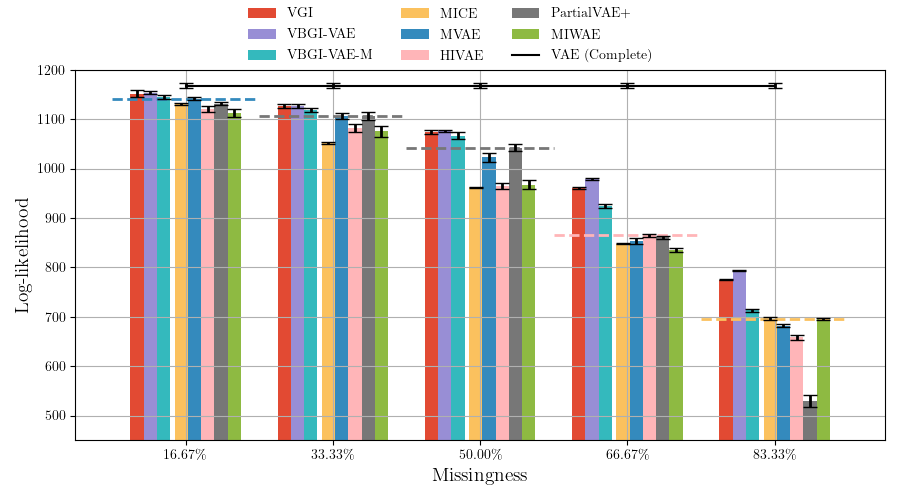

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
# axes.set(title=f'Test log-likelihood')

stats_line = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_line.items():
    stats_line[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                               seeds=exp_seed_keys,
                                                               groups=groups,
                                                               base_path=log_path_base)
plot_comparison(axes, stats_line,
                x_metric_key='group',
                y_metric_keys=('test_log_lik',),  
                err_keys=('test_log_lik_stderr',),
                xlabel='Missingness',
                ylabel='Log-likelihood', 
                colors=colors,
                ylim=(450, 1200))
    
stats_bar = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_bar.items():
    stats_bar[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                              seeds=exp_seed_keys,
                                                              groups=groups,
                                                              base_path=log_path_base)

logliks = []
num_vgi_methods = 3
for exp, s in stats_bar.items():
    if exp in ('VGI', 'VBGI-VAE', 'VBGI-VAE-M'):
        continue
    logliks.append(s['test_log_lik'])
logliks = np.array(logliks)
idx = np.argmax(logliks, axis=0)
max_loglik = logliks[idx, np.arange(idx.size)]

for i, g in enumerate(groups):
    axes.hlines(max_loglik[i], 
                xmin=np.array(g)-0.5, 
                xmax=np.array(g)+0.5,
                linestyles=['--'],
                colors=colors[1:][idx[i]+num_vgi_methods],
                linewidth=2)
    
    
barplot_comparison(axes, stats_bar, width=0.09,
                    x_metric_key='group',
                    y_metric_keys=('test_log_lik',),  
                    err_keys=('test_log_lik_stderr',),
                    xlabel='Missingness',
                    ylabel='Log-likelihood', 
                    colors=colors[1:],
#                     edgecolors=[None, 'red'] + [None]*(len(colors)-3),
                    ylim=(450, 1200),
                      gap=0.03, gap_idxs=[2]
                  )

    
# for exp, model_name in suite_subsampled.items():
#     stat_sub = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                    seeds=exp_seed_keys,
#                                                    groups=groups,
#                                                    base_path=log_path_base)
    
#     for g in range(len(stat_sub['group'])):
# #         axes.plot()
#         axes.hlines(stat_sub['test_log_lik'], 
#                     xmin=np.array(stat_sub['group'])-0.5, 
#                     xmax=np.array(stat_sub['group'])+0.5,
#                     linestyles=[':'],
#                     colors=colors[:1])
# #         breakpoint()

axes.set_xticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))

axes.grid()

fig.tight_layout(rect=(0, 0, 1, 0.90))

handles, labels = axes.get_legend_handles_labels()

handles = handles[1:] + [mpl.lines.Line2D([0], [0], color=colors[0], linestyle='-')]
labels = labels[1:] + labels[:1]

axes.legend(handles, labels,
            ncol=3, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', 
            frameon=False)

In [34]:
fig.savefig('figures/fcvae_frey_test_loglik_best_competitor.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


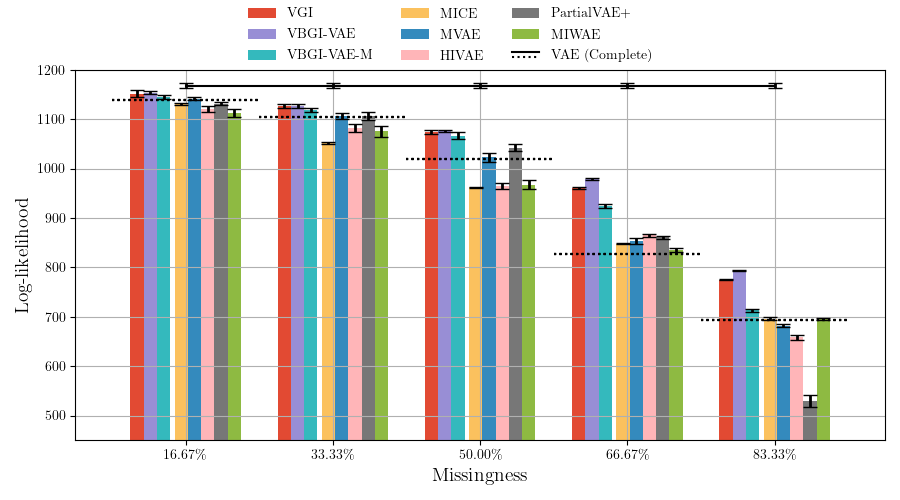

In [50]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
# # axes.set(title=f'Test log-likelihood')

# stats_line = {}
# # Load stats for every experiment in the suite
# for exp_name, model_name in suite_line.items():
#     stats_line[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                                seeds=exp_seed_keys,
#                                                                groups=groups,
#                                                                base_path=log_path_base)
# plot_comparison(axes, stats_line,
#                 x_metric_key='group',
#                 y_metric_keys=('test_log_lik',),  
#                 err_keys=('test_log_lik_stderr',),
#                 xlabel='Missingness',
#                 ylabel='Log-likelihood', 
#                 colors=colors,
#                 ylim=(450, 1200))
    
# stats_bar = {}
# # Load stats for every experiment in the suite
# for exp_name, model_name in suite_bar.items():
#     stats_bar[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                               seeds=exp_seed_keys,
#                                                               groups=groups,
#                                                               base_path=log_path_base)

# barplot_comparison(axes, stats_bar, width=0.09,
#                     x_metric_key='group',
#                     y_metric_keys=('test_log_lik',),  
#                     err_keys=('test_log_lik_stderr',),
#                     xlabel='Missingness',
#                     ylabel='Log-likelihood', 
#                     colors=colors[1:],
# #                     edgecolors=[None, 'red'] + [None]*(len(colors)-3),
#                     ylim=(450, 1200),
#                       gap=0.03, gap_idxs=[2]
#                   )

# for i, g in enumerate(groups):
#     logliks = {}
#     for exp, s in stats_bar.items():
#         if exp in ('VGI', 'VBGI-VAE', 'VBGI-VAE-M'):
#             continue
#         logliks[exp] = s['test_log_lik']
#     idx = np.argmax(logliks.values())
#     max_loglik = list(logliks.values())[idx]
#     breakpoint()
    
# # for exp, model_name in suite_subsampled.items():
# #     stat_sub = compute_avg_loglikelihood_w_std_err(model_name, 
# #                                                    seeds=exp_seed_keys,
# #                                                    groups=groups,
# #                                                    base_path=log_path_base)
    
# #     for g in range(len(stat_sub['group'])):
# # #         axes.plot()
# #         axes.hlines(stat_sub['test_log_lik'], 
# #                     xmin=np.array(stat_sub['group'])-0.5, 
# #                     xmax=np.array(stat_sub['group'])+0.5,
# #                     linestyles=[':'],
# #                     colors=colors[:1])
# # #         breakpoint()

# axes.set_xticks(groups)
# axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))

# axes.grid()

# fig.tight_layout(rect=(0, 0, 1, 0.90))

# handles, labels = axes.get_legend_handles_labels()

# handles = handles[1:] + [(mpl.lines.Line2D([0], [0], color=colors[0], linestyle='-'), 
#                           mpl.lines.Line2D([0], [0], color=colors[0], linestyle=':'))]
# labels = labels[1:] + labels[:1]

# axes.legend(handles, labels,
#             ncol=3, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', 
#             frameon=False,
#             handler_map = {tuple : HandlerTupleVertical()})

In [51]:
# fig.savefig('figures/fcvae_frey_test_loglik_subsampl.pdf', bbox_inches='tight')

### Test-loglik vs train time

In [28]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


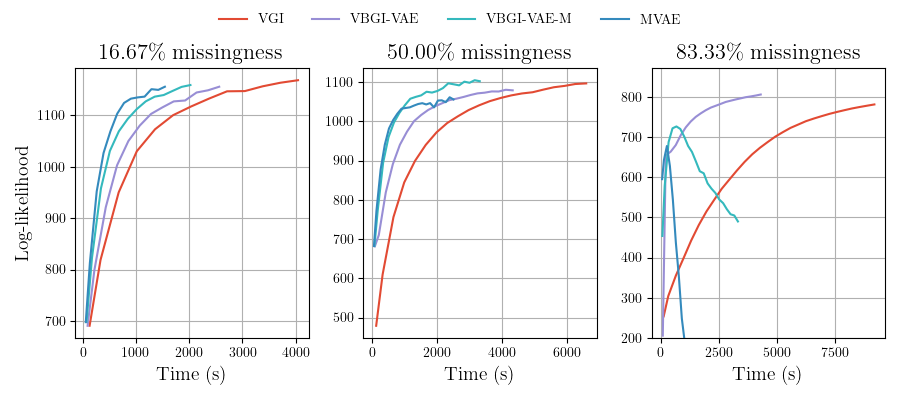

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Time (s)'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




In [24]:
# fig.savefig('figures/fcvae_frey_test_loglik_vs_time_selected.pdf', bbox_inches='tight')

### Test-loglik vs train time (all)

In [52]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
    'HI-VAE': 'fc_hivae',
    'PartialVAE+': 'fc_pvae_noaggact',
    'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
    'HI-VAE': 'refitallckpts_fc_hivae',
    'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
    'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


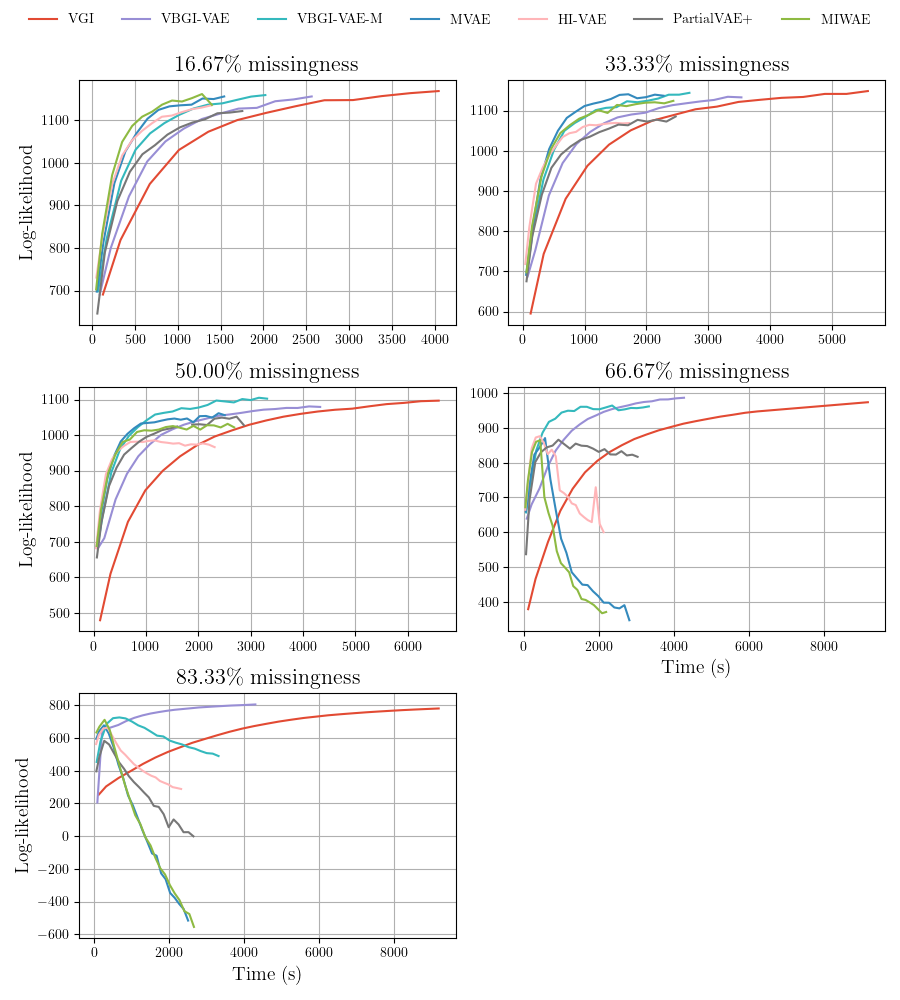

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(9, 10))
axes = axes.flatten()

# gs = [1, 3, 5]
gs = [1,2,3,4,5]
# ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    
    if i in [0, 2, 4]:
        ylabel = 'Log-likelihood'
    else:
        ylabel = None

    if i in [3, 4]:
        xlabel = 'Time (s)'
    else:
        xlabel = None
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

    
fig.delaxes(axes[-1])
fig.tight_layout(rect=(0, 0, 1, 0.96))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=7, bbox_to_anchor=(0.5, 0.98), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)

In [55]:
# fig.savefig('figures/fcvae_frey_test_loglik_vs_time_all.pdf', bbox_inches='tight')

### Test-loglik vs train epoch vs train time

In [58]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


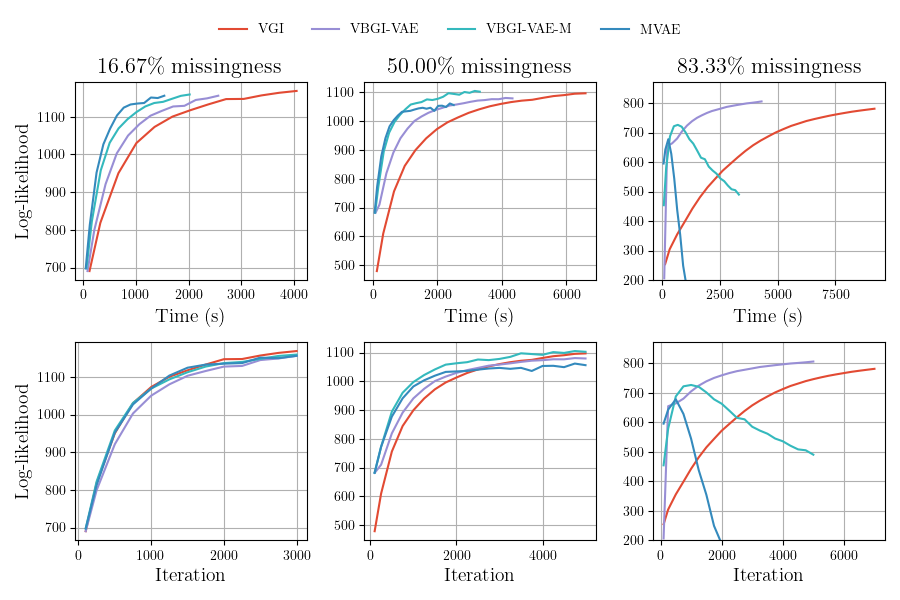

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(9, 6))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Time (s)'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])
    
    xlabel = 'Iteration'
    
    plot_comparison(axes[i+len(gs)], stats, 
                    x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




### Test-loglik vs train epoch

In [66]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

<IPython.core.display.Javascript object>


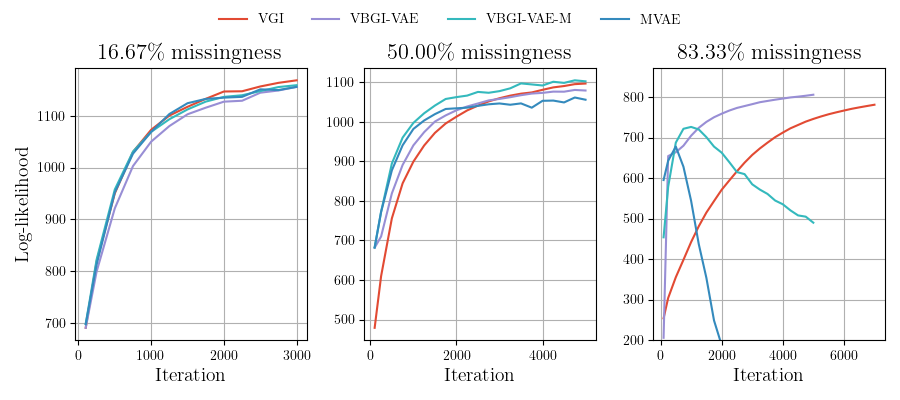

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
axes = axes.flatten()

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Iteration'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

#     axes[i].yaxis.set_visible(False)

fig.tight_layout(rect=(0, 0, 1, 0.93))

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




In [70]:
# fig.savefig('figures/fcvae_frey_test_loglik_vs_epoch_selected.pdf', bbox_inches='tight')

### Test-loglik vs train epoch and avg train iteration time

In [90]:
suite = {
#     'Complete MLE (Fitted on original data)': '../../../frey_faces_processed/fcvae_for_synthetic_data/1/fcvae_complete_data',
#     'VAE (Complete)': 'fcvae_complete_data',
    'VGI': 'fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise',
    
#     'MICE': 'fcvae_mice_baseline',
    'MVAE': 'fc_mvae',
#     'HI-VAE': 'fc_hivae',
#     'PartialVAE+': 'fc_pvae_noaggact',
#     'MIWAE': 'fc_miwae',
#     "MIWAE (Complete)": "fc_miwae_complete",
#     "MVAE (Complete)": "fc_mvae_complete"
}

suite_refit = {
    'VGI': 'refitallckpts_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refitallckpts_fcvae_pretrained_svar_cdi_marginalise_k5_const',
    'VBGI-VAE': 'refitallckpts_fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'refitallckpts_fcvae_mcimp_marginalise',
    
    'MVAE': 'refitallckpts_fc_mvae',
#     'HI-VAE': 'refitallckpts_fc_hivae',
#     'PartialVAE+': 'refitallckpts_fc_pvae_noaggact',
#     'MIWAE': 'refitallckpts_fc_miwae',
}

refit_ckpts = {
    'MIWAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'MVAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'PartialVAE+': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'HI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VGI': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, 
              5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750,  -1]],
#     'VGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
#               [100, 250, 500, 750, 1000, 1250, 
#               1500, 1750, 2000, 2250, 2500, 2750, 3000, 
#               3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
    'VBGI-VAE-M': [[100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1],
              [100, 250, 500, 750, 1000, 1250, 
              1500, 1750, 2000, 2250, 2500, 2750, 3000, 
              3250, 3500, 3750, 4000, 4250, 4500, 4750, -1]],
}

imp_time_suite = {
    'VGI': 'fcvae_pretrained_svar_cdi_const_time',
#     'VGI-VAE': 'fcvae_pretrained_svar_cdi_marginalise_k5_const_time',
    'VBGI-VAE': 'fcvae_mcimp_bvgi2_vardecinputxmask_k5_g1',
    'VBGI-VAE-M': 'fcvae_mcimp_marginalise', 
}

final_epochs = {
    'VGI': ['last', 'last', 'last', 'last', 'last'],
#     'VGI-VAE': ['last', 'last', 'last', 2750, 1000],
    'VBGI-VAE': ['last', 'last', 'last', 'last', 'last'],
    'VBGI-VAE-M': ['last', 'last', 'last', 'last', 1000],
    
    'MVAE': ['last', 'last', 'last', 1000, 500],
    'HI-VAE': ['last', 'last', 'last', 1000, 500],
    'PartialVAE+': ['last', 'last', 'last', 1500, 500],
    'MIWAE': ['last', 'last', 'last', 1000, 500],
}

<IPython.core.display.Javascript object>


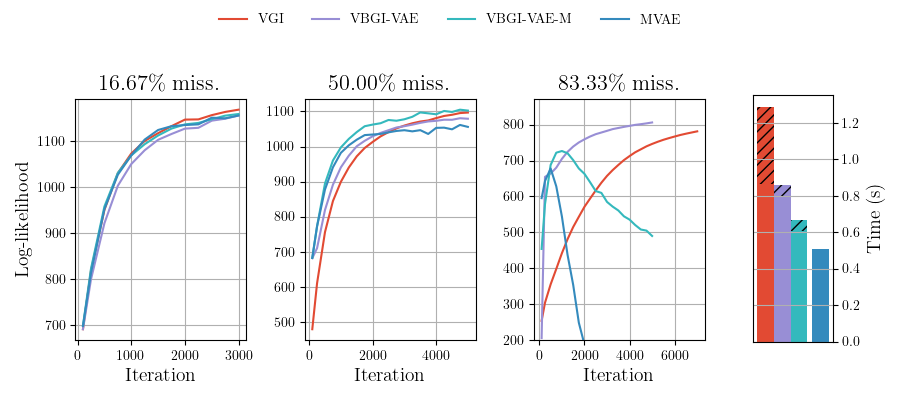

<ipython-input-130-dffc4ac6b769>:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs1.tight_layout(fig, rect=[0, 0, 0.8, 0.85])  #top=0.85, left=0.08, right=0.80
<ipython-input-130-dffc4ac6b769>:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0.82, 0.09, 1, 0.8])  #to/p=0.85, left=0.82, right=0.92


In [130]:
# fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(9, 4))
# axes = axes.flatten()
fig = plt.figure(constrained_layout=False, figsize=(9, 4))
# gridspec = fig.add_gridspec(1, 11)
gs1 = fig.add_gridspec(nrows=1, ncols=3, top=0.85, right=0.80)
gs2 = fig.add_gridspec(nrows=1, ncols=1, top=0.85, left=0.82)

axes = []
axes.append(fig.add_subplot(gs1[0]))
axes.append(fig.add_subplot(gs1[1]))
axes.append(fig.add_subplot(gs1[2]))
axes.append(fig.add_subplot(gs2[0]))

gs = [1, 3, 5]
ylims = [None, None, (200, None)]
time_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats = {}
    for exp_name, model_name in suite.items():
        stats[exp_name] = compute_avg_test_loglikelihood_vs_train_time(orig_model=model_name, 
                                                                       refit_model=suite_refit[exp_name],
                                                                       seeds=[exp_seed_keys[0]],
                                                                       ckpts=refit_ckpts[exp_name][g-1],
                                                                       group=g,
                                                                       base_path=log_path_base)
#         time_stats[exp_name]['time_per_epoch'].append(stats[exp_name]['train_time'][-1]/stats[exp_name]['epoch'][-1])
#         time_stats[exp_name]['imp_time_per_epoch'].append(stats[exp_name]['train_imp_time'][-1]/stats[exp_name]['epoch'][-1])

    axes[i].set_title(label=f'{g/6*100:.2f}\% miss.', fontdict={'fontsize': 16})
    if i in (0, ):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    xlabel = 'Iteration'
        
    plot_comparison(axes[i], stats, 
                    x_metric_key='epoch',
#                     y_metric_keys=('train_log_lik', 'val_log_lik'),
#                     err_keys=(None, None,),
                    y_metric_keys=('test_log_lik', ),
                    err_keys=(None, ),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=ylims[i],
                    legend=False,
                    colors=colors[1:4]+ colors[5:])

# Time plot
    
stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    for m in suite.keys():
        # add padding for other methods
        if m in imp_time_suite:
            stats[m]['train_time'].append(0)
            stats[m]['group'].append(g)
        else:
            s = stats_g[m]
#             if final_epochs[m][g-1] == 'last':
#                 time = np.mean(s['train_time'], axis=1)
#             else:
                # If we early-stopping, count time until stopped
#                 time = np.mean(np.array(s['train_time'])[:, :final_epochs[m][g-1]], axis=1)
            time = np.mean(np.array(s['train_time']), axis=1)

            stats[m]['train_time'].append(time.mean())
            stats[m]['group'].append(g)

for m, s in stats.items():
    stats[m]['train_time'] = [np.mean(stats[m]['train_time'])]
    stats[m]['dummy'] = [1]

# Imputation time in VGI methods
imp_stats = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats_g = read_suite_stats_with_init(group=g, suite=imp_time_suite, seed=exp_seed_keys[0])
    for m in suite.keys():
        # add padding for other methods
        if m not in imp_time_suite:
            imp_stats[m]['train_time_minus_imp_time'].append(0)
            imp_stats[m]['group'].append(g)
        else:
            s = stats_g[m]
#             if final_epochs[m][g-1] == 'last':
#                 imp_time = np.array(s['train_imp_time'])
#                 train_time = np.array(s['train_time'])
#                 time = train_time - imp_time
#             else:
#                 # If we early-stopping, count time until stopped
#                 imp_time = np.array(s['train_imp_time'])[:final_epochs[m][g-1]]
#                 train_time = np.array(s['train_time'])[:final_epochs[m][g-1]]
#                 time = train_time - imp_time
            imp_time = np.array(s['train_imp_time'])
            train_time = np.array(s['train_time'])
            time = train_time - imp_time

            imp_stats[m]['train_time_minus_imp_time'].append(np.mean(time))
            imp_stats[m]['train_time'].append(np.mean(train_time))
            imp_stats[m]['train_imp_time'].append(np.mean(imp_time))
            imp_stats[m]['group'].append(g)

for m, s in imp_stats.items():
    imp_stats[m]['train_imp_time'] = [np.mean(imp_stats[m]['train_imp_time'])]
    imp_stats[m]['train_time_minus_imp_time'] = [np.mean(imp_stats[m]['train_time_minus_imp_time'])]
    imp_stats[m]['dummy'] = [1]
            

barplot_comparison(axes[-1], imp_stats, width=0.11,
                   gap=0.03, gap_idxs=[2],
                    x_metric_key='dummy',
                    y_metric_keys=('train_imp_time',),  
                    err_keys=(None,),
                    y_bott_keys=('train_time_minus_imp_time',),
                    xlabel='Missingness',
                    ylabel='Time (s)', 
                    colors=colors[1:4] + colors[5:],
                    hatches=['///']*3 + [None]*4,
                    alpha=0.999,  # Workaround for hatches disappearing when rendering to pdf
                   legend=False
                  )
    
barplot_comparison(axes[-1], imp_stats, width=0.11,
                   gap=0.03, gap_idxs=[2],
                    x_metric_key='dummy',
                    y_metric_keys=('train_time_minus_imp_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel=None, 
                    colors=colors[1:4] + colors[5:],
                   legend=False
                  )

barplot_comparison(axes[-1], stats, width=0.11,
                   gap=0.03, gap_idxs=[2],
                    x_metric_key='dummy',
                    y_metric_keys=('train_time',),  
                    err_keys=(None,),
                    xlabel=None,
                    ylabel='Time (s)', 
                    colors=colors[1:4] + colors[5:],
#                     hatches=['///']*2 + [None]*4,
                   legend=False
                  )

axes[-1].yaxis.tick_right()
axes[-1].yaxis.set_label_position("right")
axes[-1].set_xticks([])
# axes[-1].grid()

# fig.tight_layout(rect=(0, 0, 1, 0.80))
gs1.tight_layout(fig, rect=[0, 0, 0.8, 0.85])
gs2.tight_layout(fig, rect=[0.82, 0.1, 1, 0.8])

# recttuple (left, bottom, right, top)
axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, loc='center', 
               frameon=False)




### Log-likelihood analysis (Z-dim=5)

In [123]:
suite_line = {
    'VAE (Complete)': 'refit_fcvae_complete_data',
}


suite_bar = {
#     'VAE (Complete)': 'refit_fcvae_complete_data',
#     'VGI': 'refit_fcvae_pretrained_svar_cdi_const',
#     'VGI-VAE': 'refit_fcvae_pretrained_svar_cdi_marginalise_k5_const',
#     'MICE': 'refit_fcvae_mice_baseline',
    'MVAE': 'refit_fc_mvae_zdim5',
#     'HIVAE': 'refit_fc_hivae',
#     'PartialVAE+': 'refit_fc_pvae_noaggact',
    'MIWAE': 'refit_fc_miwae_zdim5',
}
groups = [1, 2, 3, 4, 5]

<IPython.core.display.Javascript object>


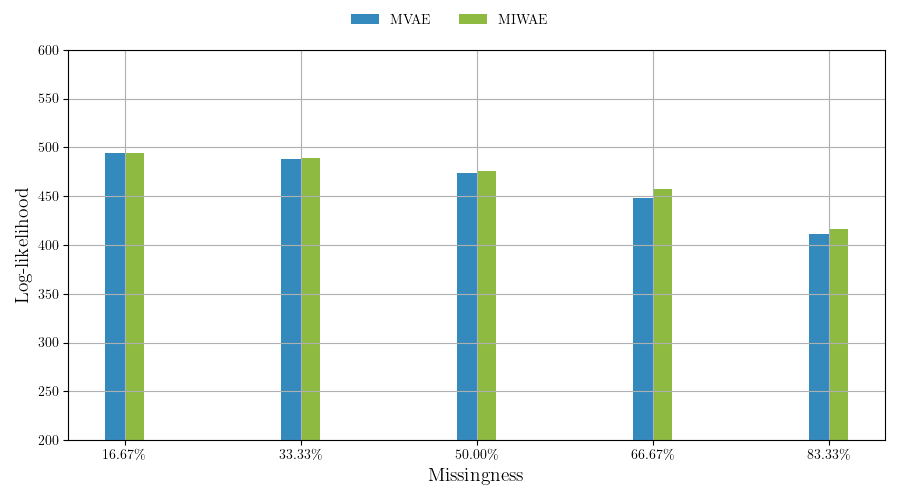

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
# axes.set(title=f'Test log-likelihood')

# ggplot
colors = ['#000000', '#E24A33', '#988ED5', '#FBC15E', '#348ABD', '#FFB5B8', '#777777', '#8EBA42',]

# stats_line = {}
# # Load stats for every experiment in the suite
# for exp_name, model_name in suite_line.items():
#     stats_line[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
#                                                               seeds=[exp_seed_keys[0]],
#                                                               groups=groups,
#                                                          base_path=log_path_base)
# plot_comparison(axes, stats_line,
#                 x_metric_key='group',
#                 y_metric_keys=('test_log_lik',),  
#                 err_keys=('test_log_lik_stderr',),
#                 xlabel='Missingness',
#                 ylabel='Log-likelihood', 
#                 colors=colors,
#                 ylim=(450, 1200))
    
stats_bar = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite_bar.items():
    stats_bar[exp_name] = compute_avg_loglikelihood_w_std_err(model_name, 
                                                              seeds=[exp_seed_keys[0]],
                                                              groups=groups,
                                                              base_path=log_path_base)

barplot_comparison(axes, stats_bar, width=0.11,
                    x_metric_key='group',
                    y_metric_keys=('test_log_lik',),  
                    err_keys=('test_log_lik_stderr',),
                    xlabel='Missingness',
                    ylabel='Log-likelihood', 
                    colors=['#348ABD','#8EBA42'],
                    ylim=(200, 600),
#                       gap=0.02, gap_idx=1
                  )

axes.set_xticks(groups)
axes.set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))

# axes.grid()

fig.tight_layout(rect=(0, 0, 1, 0.94))

axes.legend(ncol=4, bbox_to_anchor=(0.5, 0.96), bbox_transform=fig.transFigure, loc='center', 
                  frameon=False)

In [129]:
# fig.savefig('figures/fcvae_frey_test_loglik_zdim5.pdf', bbox_inches='tight')

### Investigate z posterior (on train data)

#### MIWAE

##### 16\%

In [36]:
z_posterior = np.load(log_path_base + '/1/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean = z_posterior['z_mean']
z_log_var = z_posterior['z_log_var']

z_dispersion = np.exp(z_log_var)/z_mean
z_dispersion_var = np.std(z_dispersion, ddof=1, axis=0)**2

z_mean_var = np.std(z_mean, ddof=1, axis=0)**2

In [23]:
z_mean

array([[-0.8595819 , -0.4801935 ,  0.73855597, ..., -0.5314161 ,
        -0.35069364,  1.6684651 ],
       [-1.3337665 , -0.76007444, -0.4594952 , ...,  0.71212083,
         0.06283414,  0.2775131 ],
       [ 0.3655759 ,  0.01031695, -0.0142732 , ..., -1.1195475 ,
         0.543473  , -2.088836  ],
       ...,
       [ 1.927636  , -0.23798777,  1.375038  , ...,  0.11259982,
        -0.60375166, -1.5403249 ],
       [ 1.1343204 , -0.42708987,  0.85398173, ..., -0.38520807,
        -0.6341264 , -0.54895884],
       [-0.18053731, -0.75657535, -0.48046792, ..., -0.80635625,
         0.06966911,  0.5484797 ]], dtype=float32)

In [24]:
np.exp(z_log_var)

array([[0.000312  , 0.00040824, 0.00049448, ..., 0.00027035, 0.00028727,
        0.00039953],
       [0.00040119, 0.00043832, 0.00063339, ..., 0.00038848, 0.00045267,
        0.00046699],
       [0.00034932, 0.00038402, 0.00026102, ..., 0.00022675, 0.0003026 ,
        0.00038774],
       ...,
       [0.00156301, 0.00155087, 0.00197669, ..., 0.00100243, 0.00160667,
        0.00131061],
       [0.00103522, 0.00128933, 0.00125004, ..., 0.00104336, 0.00130194,
        0.00104661],
       [0.00025257, 0.0003651 , 0.00026736, ..., 0.00023803, 0.00028471,
        0.00029399]], dtype=float32)

In [11]:
# fig, axes = plt.subplots(1, 1, figsize=(4, 3))

# axes.hist(z_dispersion_var, bins=20)

# fig.tight_layout()

<IPython.core.display.Javascript object>


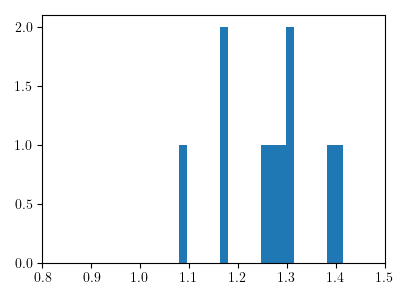

(0.8, 1.5)

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var, bins=20)

fig.tight_layout()

axes.set_xlim(0.8, 1.5)

<IPython.core.display.Javascript object>


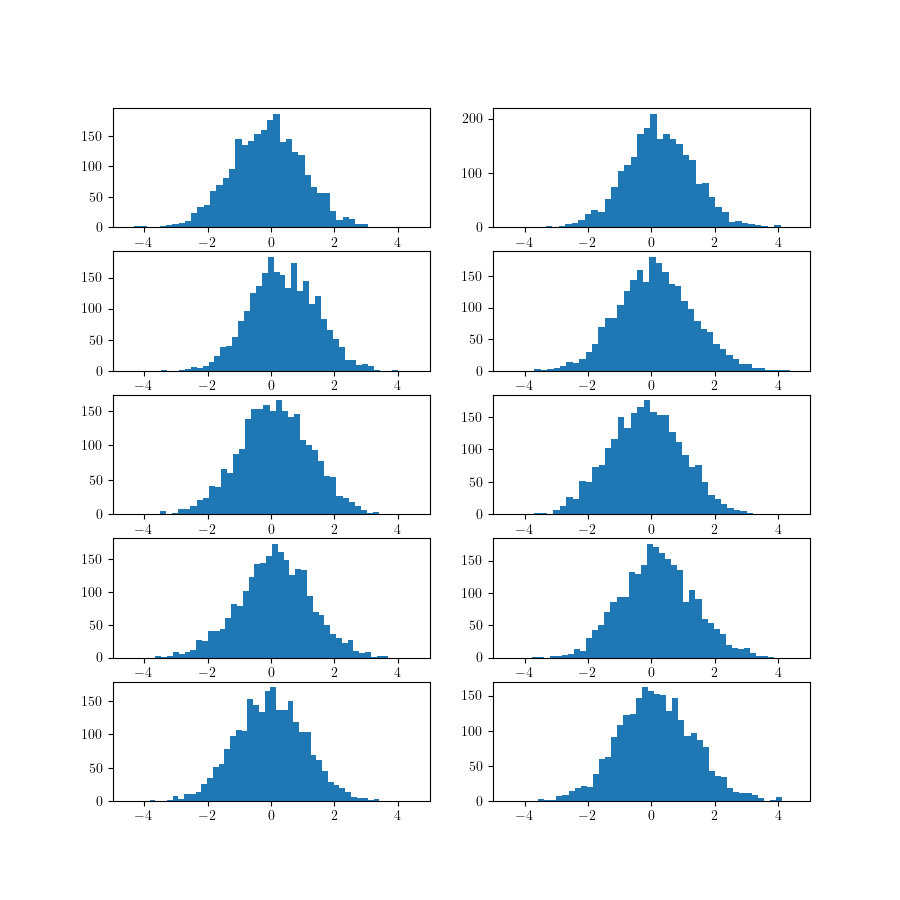

In [27]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_mean[:, i], bins=40)
    ax.set_xlim(-5, 5)

<IPython.core.display.Javascript object>


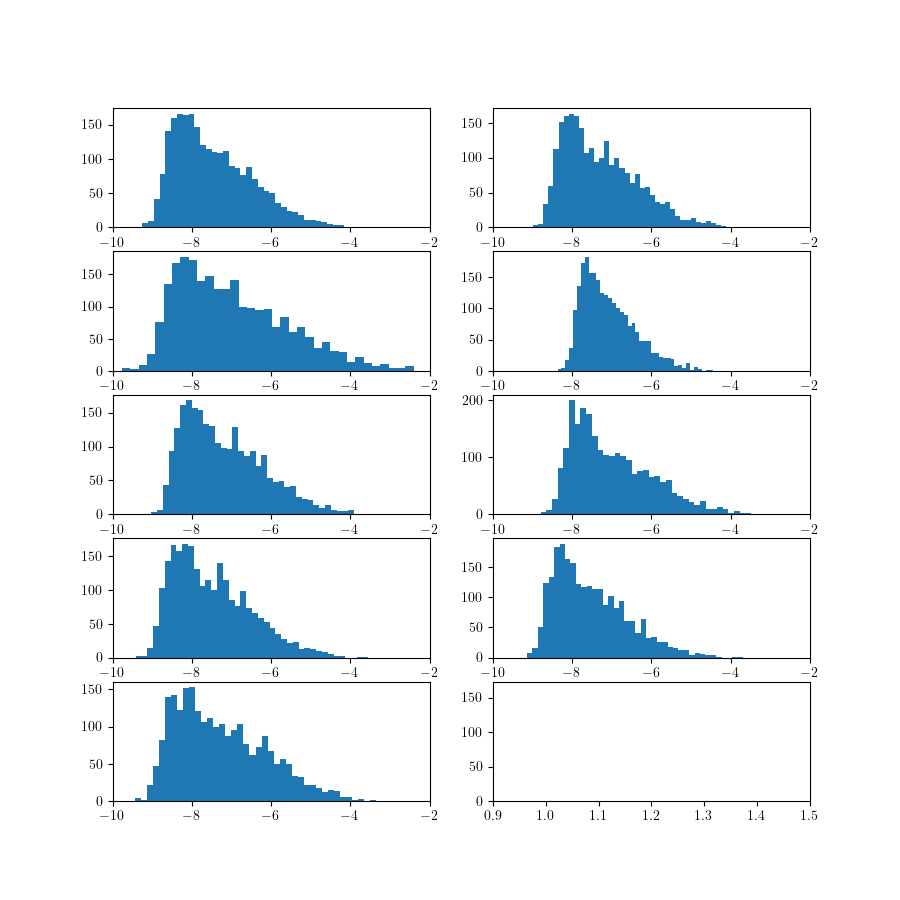

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_log_var[:, i], bins=40)
    ax.set_xlim(-10, -2)

##### 83\%

In [38]:
z_posterior = np.load(log_path_base + '/5/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean = z_posterior['z_mean']
z_log_var = z_posterior['z_log_var']

z_dispersion = np.exp(z_log_var)/z_mean
z_dispersion_var = np.std(z_dispersion, ddof=1, axis=0)**2

z_mean_var = np.std(z_mean, ddof=1, axis=0)**2

In [30]:
z_mean

array([[-0.42993227, -0.9056605 ,  1.9513716 , ..., -0.39666098,
        -0.2158689 ,  0.6437558 ],
       [-0.77469033, -0.9868765 , -0.68871593, ...,  0.7579465 ,
        -0.58766985,  1.0996277 ],
       [ 0.04236281,  0.19774893,  0.18404345, ..., -0.25511   ,
        -0.08170246, -1.2569113 ],
       ...,
       [ 1.1440754 ,  0.6870522 ,  0.6544603 , ...,  0.23882166,
        -0.04862954, -1.0885952 ],
       [ 0.9656405 ,  0.7500113 ,  1.5622317 , ..., -1.0145078 ,
        -0.0507399 , -0.6791578 ],
       [ 0.3206877 , -0.21366163, -0.09434888, ..., -0.4107629 ,
        -0.29884258,  1.0455048 ]], dtype=float32)

In [31]:
np.exp(z_log_var)

array([[0.00133889, 0.00102252, 0.00102514, ..., 0.00107048, 0.00151388,
        0.00053936],
       [0.00187961, 0.00096089, 0.00089717, ..., 0.00128341, 0.00182414,
        0.00081752],
       [0.00145622, 0.00074883, 0.00063714, ..., 0.00110295, 0.00120725,
        0.00056399],
       ...,
       [0.00290431, 0.00193055, 0.00197414, ..., 0.00182786, 0.00283024,
        0.00122043],
       [0.00304409, 0.00250536, 0.00737814, ..., 0.00250715, 0.00399252,
        0.00124319],
       [0.00166231, 0.00094448, 0.00107496, ..., 0.00111454, 0.00191999,
        0.00078273]], dtype=float32)

In [32]:
# fig, axes = plt.subplots(1, 1, figsize=(4, 3))

# axes.hist(z_dispersion_var, bins=20)

# fig.tight_layout()

<IPython.core.display.Javascript object>


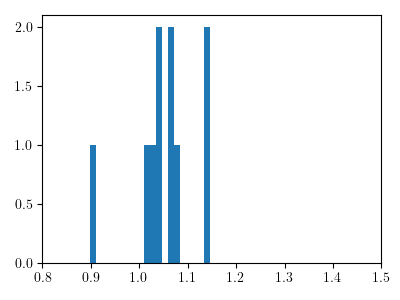

(0.8, 1.5)

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var, bins=20)

fig.tight_layout()
axes.set_xlim(0.8, 1.5)

In [19]:
# fig, axes = plt.subplots(5, 2, figsize=(9,9))

# axes = axes.flatten()
# for i, ax in enumerate(axes):
#     ax.hist(z_dispersion[:, i])

<IPython.core.display.Javascript object>


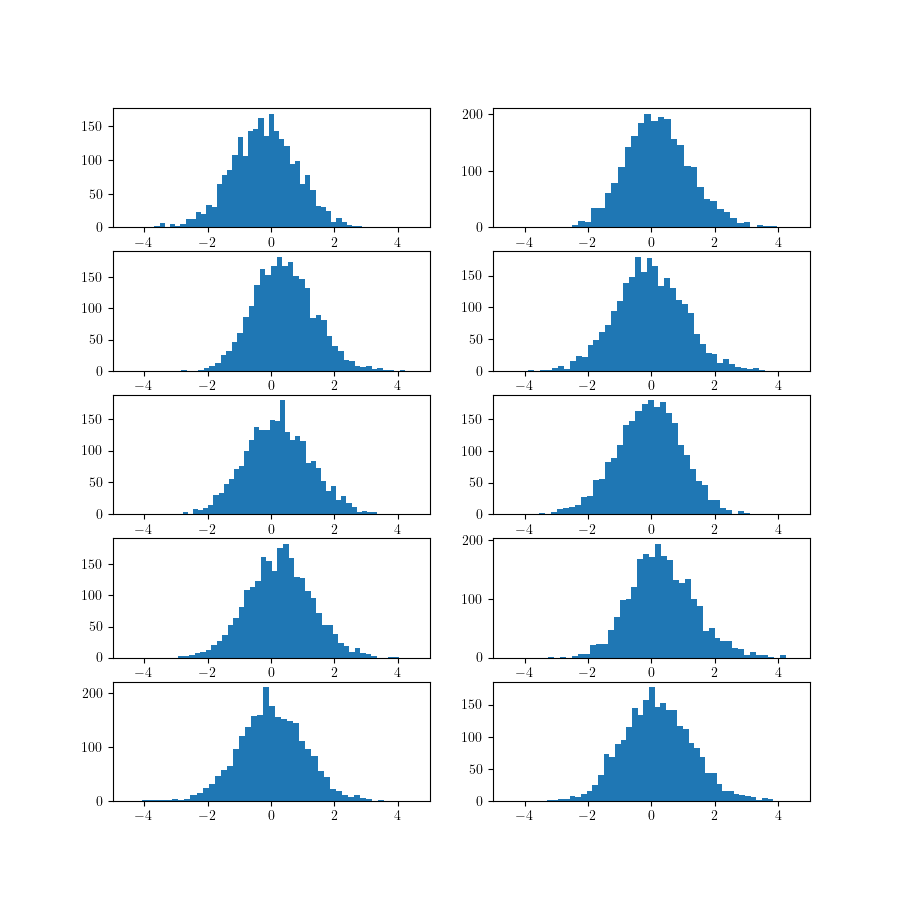

In [40]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_mean[:, i], bins=40)
    ax.set_xlim(-5, 5)

<IPython.core.display.Javascript object>


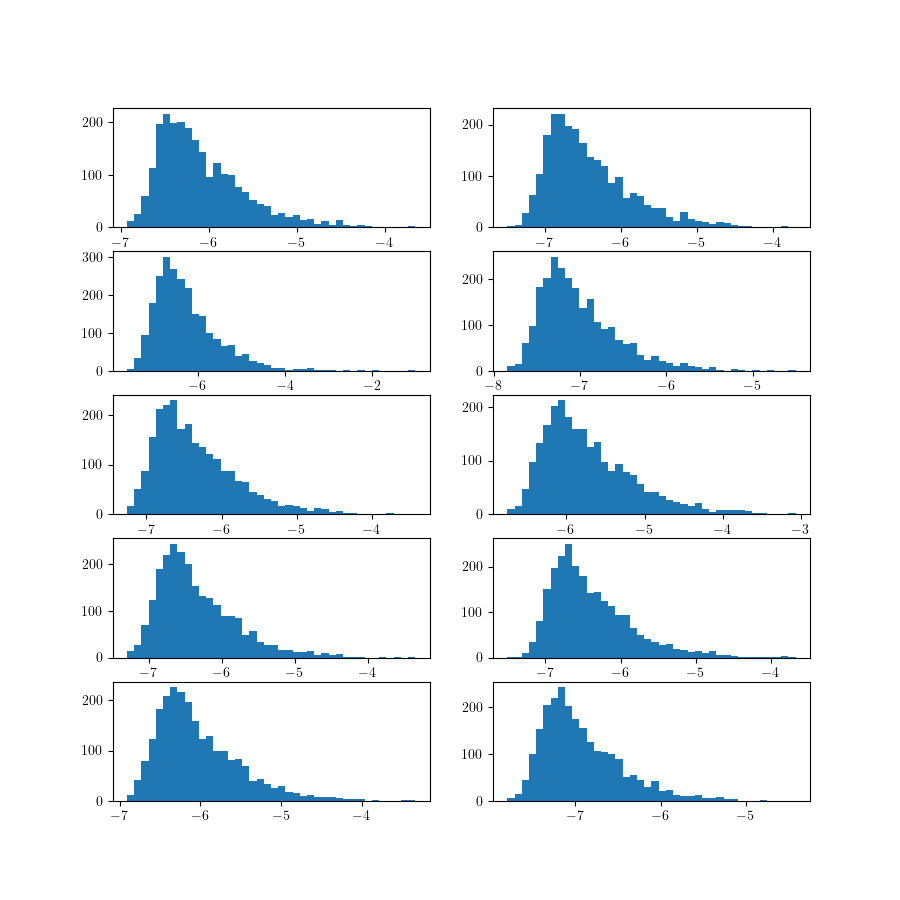

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_log_var[:, i], bins=40)

##### Z-mean variance 16\% vs 50\% vs 18\%

In [75]:
z_posterior_1 = np.load(log_path_base + '/1/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_3 = np.load(log_path_base + '/3/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_5 = np.load(log_path_base + '/5/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean_1 = z_posterior_1['z_mean']
z_log_var_1 = z_posterior_1['z_log_var']

z_mean_3 = z_posterior_3['z_mean']
z_log_var_3 = z_posterior_3['z_log_var']

z_mean_5 = z_posterior_5['z_mean']
z_log_var_5 = z_posterior_5['z_log_var']

z_mean_var_1 = np.std(z_mean_1, ddof=1, axis=0)**2
z_mean_var_3 = np.std(z_mean_3, ddof=1, axis=0)**2
z_mean_var_5 = np.std(z_mean_5, ddof=1, axis=0)**2

<IPython.core.display.Javascript object>


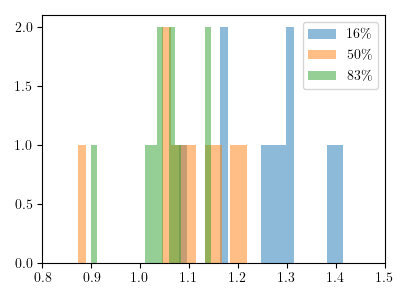

(0.8, 1.5)

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var_1, bins=20, label='16\%', alpha=0.5)
axes.hist(z_mean_var_3, bins=20, label='50\%', alpha=0.5)
axes.hist(z_mean_var_5, bins=20, label='83\%', alpha=0.5)

fig.tight_layout()

axes.legend()
axes.set_xlim(0.8, 1.5)

#### MVAE

##### 16\%

In [41]:
z_posterior = np.load(log_path_base + '/1/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean = z_posterior['z_mean']
z_log_var = z_posterior['z_log_var']

z_dispersion = np.exp(z_log_var)/z_mean
z_dispersion_var = np.std(z_dispersion, ddof=1, axis=0)**2

z_mean_var = np.std(z_mean, ddof=1, axis=0)**2

In [42]:
z_mean

array([[-0.18619081, -1.0633435 ,  1.5640492 , ..., -0.20278443,
         0.03723427,  1.1591809 ],
       [-1.7432591 , -0.14227693, -0.91348326, ...,  0.5004332 ,
        -0.07851994,  0.6732808 ],
       [-0.1782484 , -0.27234405, -0.7616979 , ..., -0.6304292 ,
         0.33221093, -2.2866428 ],
       ...,
       [ 1.3234575 ,  0.4606921 ,  0.92813706, ...,  0.27591527,
        -0.5341814 , -1.4923645 ],
       [ 0.8820039 , -0.3815229 ,  1.063485  , ...,  0.06283243,
        -0.3752604 , -0.44136462],
       [-0.30288818, -1.0072147 , -0.8248888 , ..., -0.5003599 ,
         0.3372666 ,  0.5259735 ]], dtype=float32)

In [43]:
np.exp(z_log_var)

array([[9.25818531e-05, 1.21010838e-04, 2.17028879e-04, ...,
        1.35812297e-04, 1.71404710e-04, 9.69063040e-05],
       [1.73575580e-04, 1.72796674e-04, 2.69827753e-04, ...,
        1.96273555e-04, 2.15969281e-04, 1.33932233e-04],
       [7.03867627e-05, 9.16747013e-05, 1.30914807e-04, ...,
        9.23246625e-05, 1.19540695e-04, 7.70266342e-05],
       ...,
       [6.01110165e-04, 6.74762763e-04, 1.06039585e-03, ...,
        8.36413354e-04, 9.76896845e-04, 5.88397961e-04],
       [5.20467875e-04, 6.45466207e-04, 9.94062400e-04, ...,
        7.08763022e-04, 9.51109396e-04, 5.94513956e-04],
       [9.23597108e-05, 1.22648096e-04, 1.85678728e-04, ...,
        1.33972091e-04, 1.40974720e-04, 8.97362333e-05]], dtype=float32)

In [44]:
# fig, axes = plt.subplots(1, 1, figsize=(4, 3))

# axes.hist(z_dispersion_var, bins=20)

# fig.tight_layout()

<IPython.core.display.Javascript object>


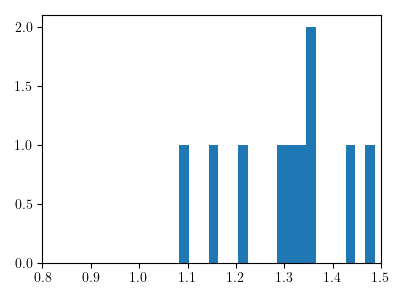

(0.8, 1.5)

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var, bins=20)

fig.tight_layout()
axes.set_xlim(0.8, 1.5)

<IPython.core.display.Javascript object>


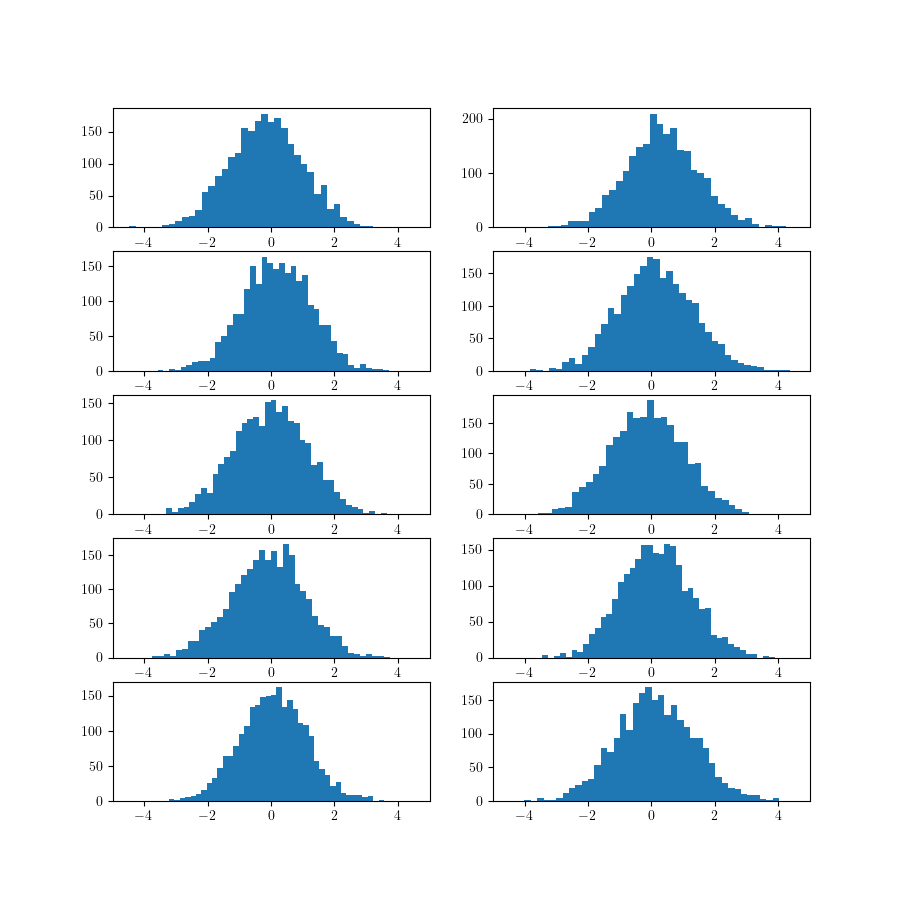

In [47]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_mean[:, i], bins=40)
    ax.set_xlim(-5, 5)

<IPython.core.display.Javascript object>


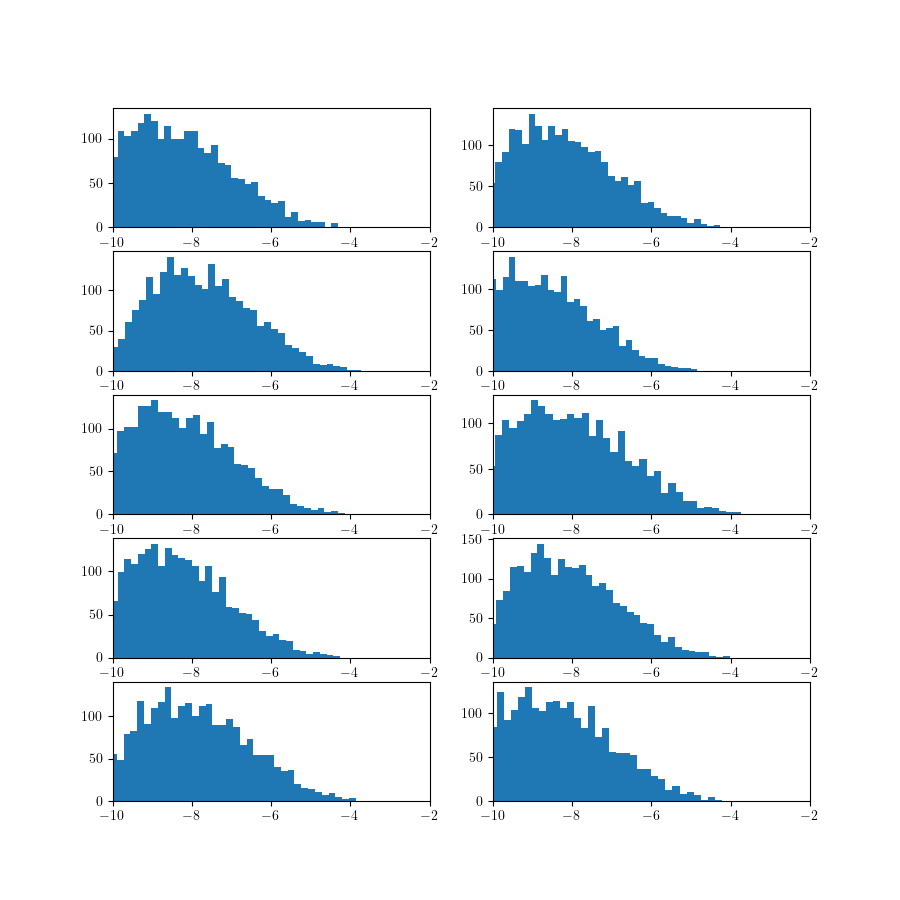

In [48]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_log_var[:, i], bins=40)
    ax.set_xlim(-10, -2)

##### 83\%

In [49]:
z_posterior = np.load(log_path_base + '/5/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean = z_posterior['z_mean']
z_log_var = z_posterior['z_log_var']

z_dispersion = np.exp(z_log_var)/z_mean
z_dispersion_var = np.std(z_dispersion, ddof=1, axis=0)**2

z_mean_var = np.std(z_mean, ddof=1, axis=0)**2

In [50]:
z_mean

array([[-1.2239671 , -1.3794744 , -1.002796  , ..., -0.8210139 ,
        -0.19522421, -0.4589878 ],
       [-1.043145  ,  0.20725337,  1.0434455 , ...,  0.9372431 ,
        -0.08299232,  1.7981393 ],
       [-0.13007003,  1.0419402 ,  0.27084178, ...,  0.4057963 ,
         0.74285233, -0.10263866],
       ...,
       [ 1.5996662 , -0.2779281 ,  0.7113217 , ..., -0.0907753 ,
         0.8984957 , -0.45105785],
       [ 0.13686673, -1.3301346 , -0.14072621, ..., -0.8821001 ,
         0.39846483, -0.78262836],
       [-1.1644782 ,  0.2724969 , -0.24879242, ...,  0.23452544,
         0.42900276,  0.5716103 ]], dtype=float32)

In [51]:
np.exp(z_log_var)

array([[0.00044701, 0.0009669 , 0.00107845, ..., 0.00027554, 0.00182118,
        0.00078493],
       [0.00067687, 0.00112201, 0.00170689, ..., 0.00044421, 0.00215192,
        0.00093234],
       [0.00042241, 0.00059671, 0.00088306, ..., 0.00023453, 0.00136585,
        0.00048217],
       ...,
       [0.00097564, 0.00186968, 0.0028251 , ..., 0.00074332, 0.00462732,
        0.00157693],
       [0.00118954, 0.00169421, 0.0019972 , ..., 0.00062954, 0.00327278,
        0.00166452],
       [0.00036603, 0.00062064, 0.00088123, ..., 0.00019584, 0.00140742,
        0.00042307]], dtype=float32)

In [52]:
# fig, axes = plt.subplots(1, 1, figsize=(4, 3))

# axes.hist(z_dispersion_var, bins=20)

# fig.tight_layout()


<IPython.core.display.Javascript object>


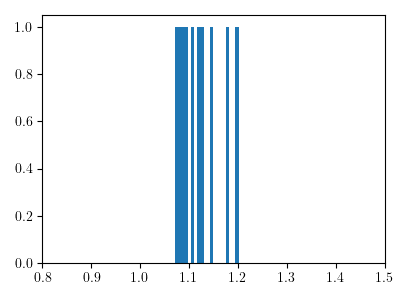

(0.8, 1.5)

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var, bins=20)

fig.tight_layout()
axes.set_xlim(0.8, 1.5)

In [54]:
# fig, axes = plt.subplots(5, 2, figsize=(9,9))

# axes = axes.flatten()
# for i, ax in enumerate(axes):
#     ax.hist(z_dispersion[:, i])

<IPython.core.display.Javascript object>


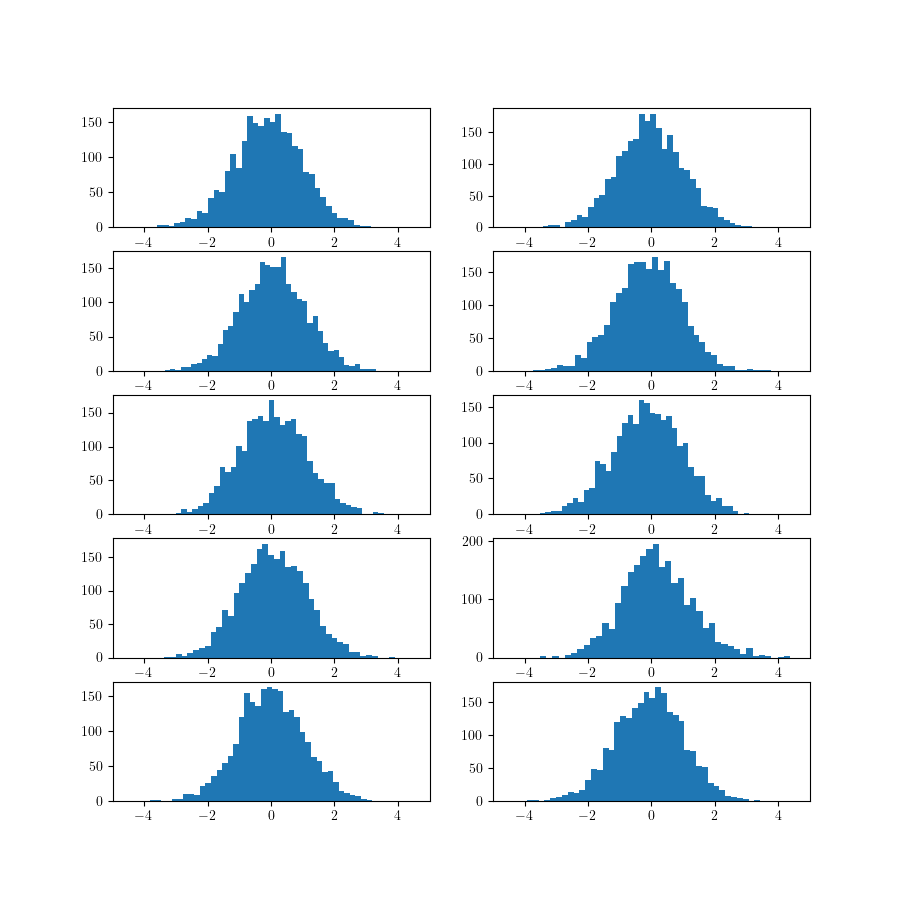

In [56]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_mean[:, i], bins=40)
    ax.set_xlim(-5, 5)

<IPython.core.display.Javascript object>


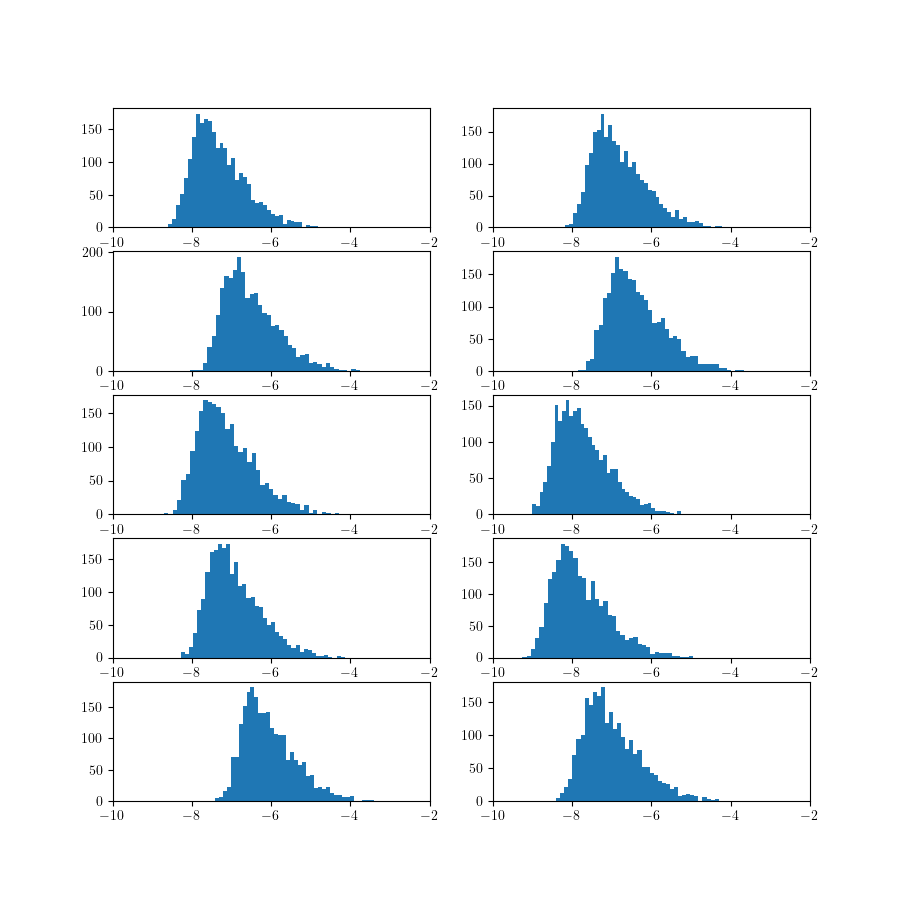

In [57]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))

axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.hist(z_log_var[:, i], bins=40)
    ax.set_xlim(-10, -2)

##### Z-mean variance 16\% vs 50\% vs 18\%

In [77]:
z_posterior_1 = np.load(log_path_base + '/1/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_3 = np.load(log_path_base + '/3/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_5 = np.load(log_path_base + '/5/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean_1 = z_posterior_1['z_mean']
z_log_var_1 = z_posterior_1['z_log_var']

z_mean_3 = z_posterior_3['z_mean']
z_log_var_3 = z_posterior_3['z_log_var']

z_mean_5 = z_posterior_5['z_mean']
z_log_var_5 = z_posterior_5['z_log_var']

z_mean_var_1 = np.std(z_mean_1, ddof=1, axis=0)**2
z_mean_var_3 = np.std(z_mean_3, ddof=1, axis=0)**2
z_mean_var_5 = np.std(z_mean_5, ddof=1, axis=0)**2

<IPython.core.display.Javascript object>


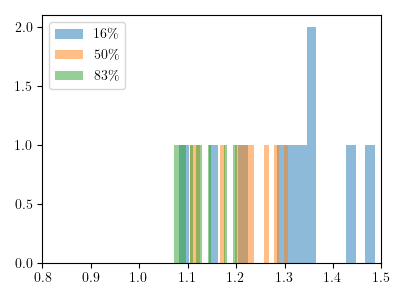

(0.8, 1.5)

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var_1, bins=20, label='16\%', alpha=0.5)
axes.hist(z_mean_var_3, bins=20, label='50\%', alpha=0.5)
axes.hist(z_mean_var_5, bins=20, label='83\%', alpha=0.5)

fig.tight_layout()

axes.legend()
axes.set_xlim(0.8, 1.5)

#### Z-mean variance MVAE vs MIWAE

In [90]:
def get_z_mean_variance(model, g):
    z_posterior = np.load(log_path_base + f'/{g}/{model}/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

    z_mean = z_posterior['z_mean']
    z_log_var = z_posterior['z_log_var']

    return np.std(z_mean, ddof=1, axis=0)**2

##### All-in-one

In [94]:
models = [(('fc_miwae_complete', 1),
          ('fcvae_complete_data', 1),),
          (('fc_miwae', 1),
          ('fc_mvae', 1),),
          (('fc_miwae', 3),
          ('fc_mvae', 3),),
          (('fc_miwae', 5),
          ('fc_mvae', 5))]

titles = ['Complete', '16\%', '50\%', '83\%']

<IPython.core.display.Javascript object>


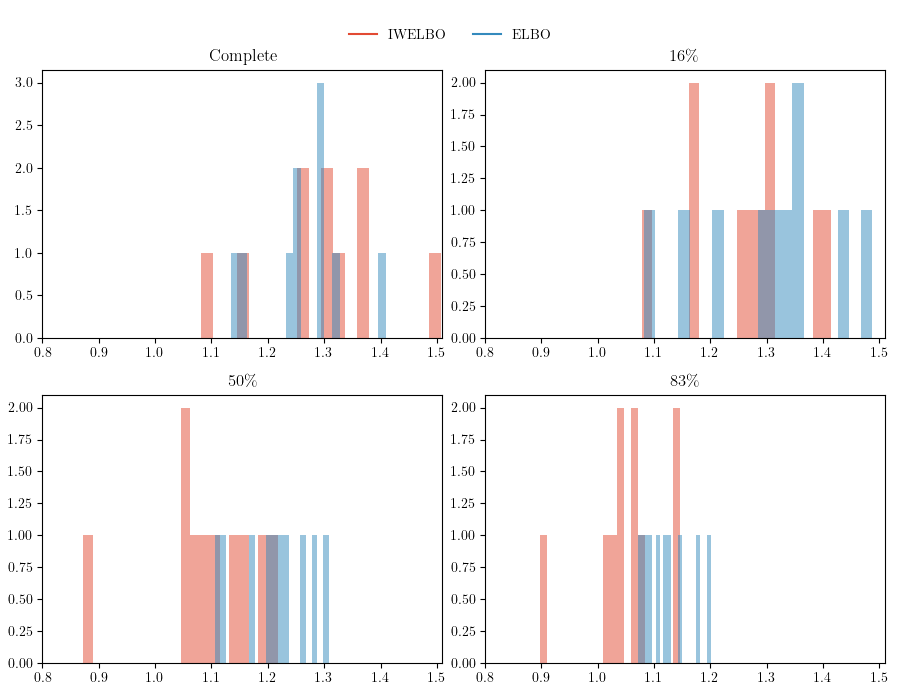

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(9,7))
axes = axes.flatten()

for i, ax in enumerate(axes):
    colors = ['#E24A33', '#348ABD']
    for c, (m, g) in zip(colors, models[i]):
        var = get_z_mean_variance(m, g)
        ax.hist(var, bins=20, color=c, alpha=0.5)
        
    ax.set_xlim(0.8, 1.51)
    ax.set_title(titles[i])

fig.tight_layout(rect=(0, 0, 1, 0.95))

handles = [
    mpl.lines.Line2D([0], [0], color='#E24A33', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#348ABD', linestyle='-'),
]
labels = [
    'IWELBO',
    'ELBO',
]

axes[0].legend(handles, labels,
            ncol=2, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, 
               loc='center', frameon=False)

##### COMPLETE

In [70]:
z_posterior_miwae = np.load(log_path_base + '/1/fc_miwae_complete/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_mvae = np.load(log_path_base + '/1/fcvae_complete_data/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean_miwae = z_posterior_miwae['z_mean']
z_log_var_miwae = z_posterior_miwae['z_log_var']

z_mean_mvae = z_posterior_mvae['z_mean']
z_log_var_mvae = z_posterior_mvae['z_log_var']

z_mean_var_miwae = np.std(z_mean_miwae, ddof=1, axis=0)**2
z_mean_var_mvae = np.std(z_mean_mvae, ddof=1, axis=0)**2

<IPython.core.display.Javascript object>


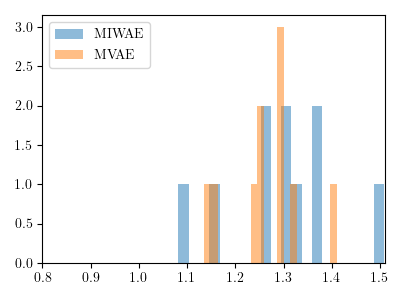

(0.8, 1.51)

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var_miwae, bins=20, label='MIWAE', alpha=0.5)
axes.hist(z_mean_var_mvae, bins=20, label='MVAE', alpha=0.5)

fig.tight_layout()

axes.legend()
axes.set_xlim(0.8, 1.51)

##### 16\%

In [66]:
z_posterior_miwae = np.load(log_path_base + '/1/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_mvae = np.load(log_path_base + '/1/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean_miwae = z_posterior_miwae['z_mean']
z_log_var_miwae = z_posterior_miwae['z_log_var']

z_mean_mvae = z_posterior_mvae['z_mean']
z_log_var_mvae = z_posterior_mvae['z_log_var']

z_mean_var_miwae = np.std(z_mean_miwae, ddof=1, axis=0)**2
z_mean_var_mvae = np.std(z_mean_mvae, ddof=1, axis=0)**2

<IPython.core.display.Javascript object>


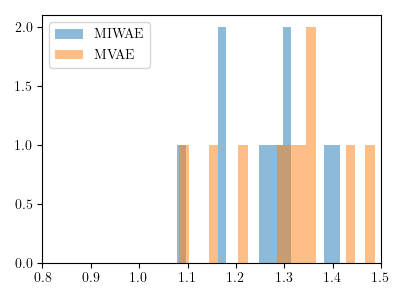

(0.8, 1.5)

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var_miwae, bins=20, label='MIWAE', alpha=0.5)
axes.hist(z_mean_var_mvae, bins=20, label='MVAE', alpha=0.5)

fig.tight_layout()

axes.legend()
axes.set_xlim(0.8, 1.5)

##### 50\%

In [79]:
z_posterior_miwae = np.load(log_path_base + '/3/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_mvae = np.load(log_path_base + '/3/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean_miwae = z_posterior_miwae['z_mean']
z_log_var_miwae = z_posterior_miwae['z_log_var']

z_mean_mvae = z_posterior_mvae['z_mean']
z_log_var_mvae = z_posterior_mvae['z_log_var']

z_mean_var_miwae = np.std(z_mean_miwae, ddof=1, axis=0)**2
z_mean_var_mvae = np.std(z_mean_mvae, ddof=1, axis=0)**2

<IPython.core.display.Javascript object>


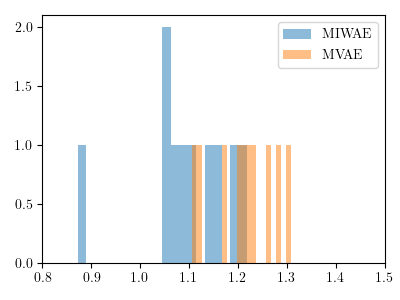

(0.8, 1.5)

In [80]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var_miwae, bins=20, label='MIWAE', alpha=0.5)
axes.hist(z_mean_var_mvae, bins=20, label='MVAE', alpha=0.5)

fig.tight_layout()

axes.legend()
axes.set_xlim(0.8, 1.5)

##### 83\%

In [68]:
z_posterior_miwae = np.load(log_path_base + '/5/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)
z_posterior_mvae = np.load(log_path_base + '/5/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/z_posterior_test.npz', allow_pickle=True)

z_mean_miwae = z_posterior_miwae['z_mean']
z_log_var_miwae = z_posterior_miwae['z_log_var']

z_mean_mvae = z_posterior_mvae['z_mean']
z_log_var_mvae = z_posterior_mvae['z_log_var']

z_mean_var_miwae = np.std(z_mean_miwae, ddof=1, axis=0)**2
z_mean_var_mvae = np.std(z_mean_mvae, ddof=1, axis=0)**2

<IPython.core.display.Javascript object>


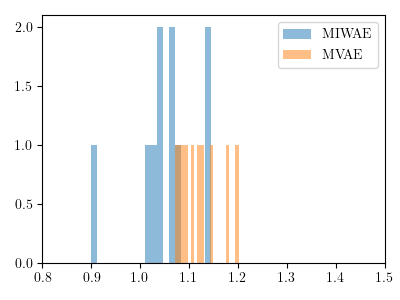

(0.8, 1.5)

In [69]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.hist(z_mean_var_miwae, bins=20, label='MIWAE', alpha=0.5)
axes.hist(z_mean_var_mvae, bins=20, label='MVAE', alpha=0.5)

fig.tight_layout()

axes.legend()
axes.set_xlim(0.8, 1.5)

##### All-in-one zdim=5

In [112]:
models = [(('fc_miwae_zdim5', 1),
          ('fc_mvae_zdim5', 1),),
#           (('fc_miwae_zdim5', 3),
#           ('fc_mvae_zdim5', 3),),
          (('fc_miwae_zdim5', 5),
          ('fc_mvae_zdim5', 5))
         ]

titles = ['16\%', '83\%']

<IPython.core.display.Javascript object>


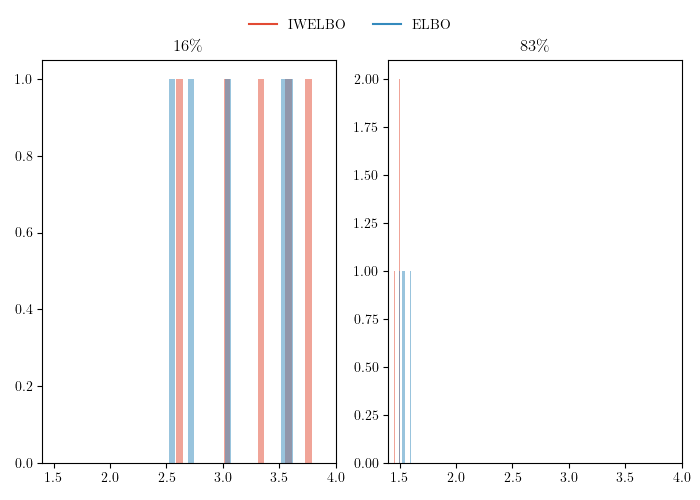

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
# axes = [axes]

for i, ax in enumerate(axes):
    colors = ['#E24A33', '#348ABD']
    for c, (m, g) in zip(colors, models[i]):
        var = get_z_mean_variance(m, g)
        ax.hist(var, bins=20, color=c, alpha=0.5)
        
    ax.set_xlim(1.4, 4.)
    ax.set_title(titles[i])

fig.tight_layout(rect=(0, 0, 1, 0.95))

handles = [
    mpl.lines.Line2D([0], [0], color='#E24A33', linestyle='-'),
    mpl.lines.Line2D([0], [0], color='#348ABD', linestyle='-'),
]
labels = [
    'IWELBO',
    'ELBO',
]

axes[0].legend(handles, labels,
            ncol=2, bbox_to_anchor=(0.5, 0.95), bbox_transform=fig.transFigure, 
               loc='center', frameon=False)

### Investigate generator sensitivity (on train data)

#### MIWAE

##### 16\%

In [202]:
gen_sens = np.load(log_path_base + '/1/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)
# list(gen_sens.keys())

<IPython.core.display.Javascript object>


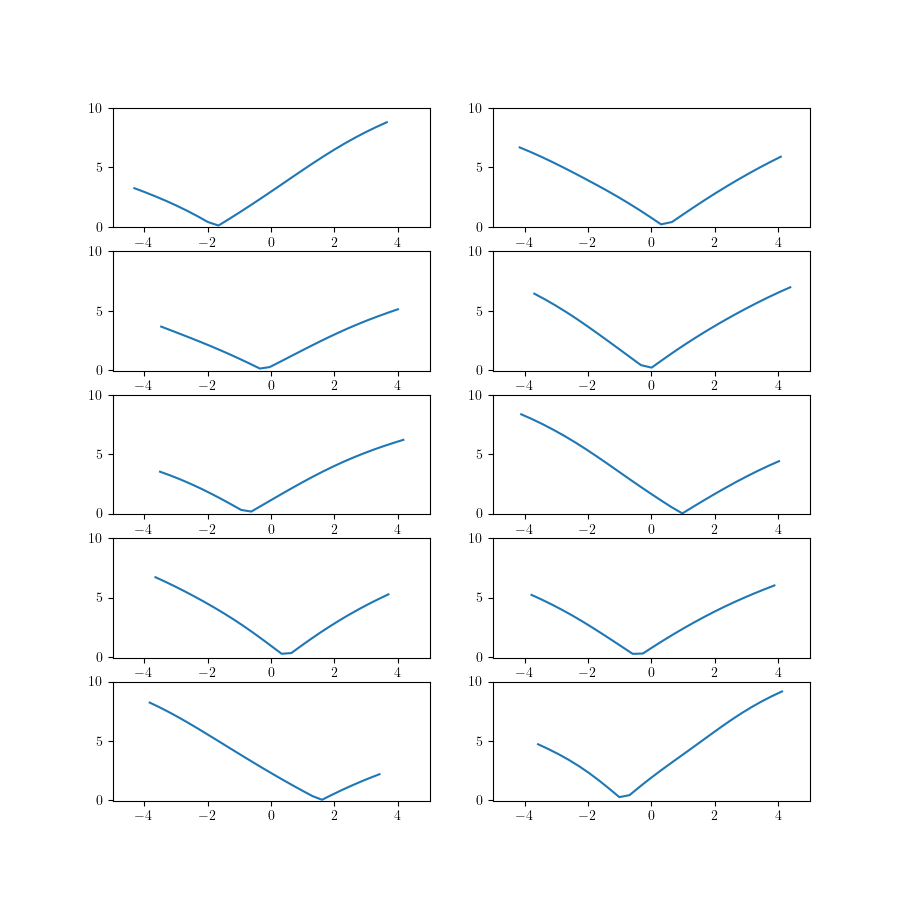

In [206]:
idx = 2

fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'][:, idx, :] - gen_sens['X_mean'][idx], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


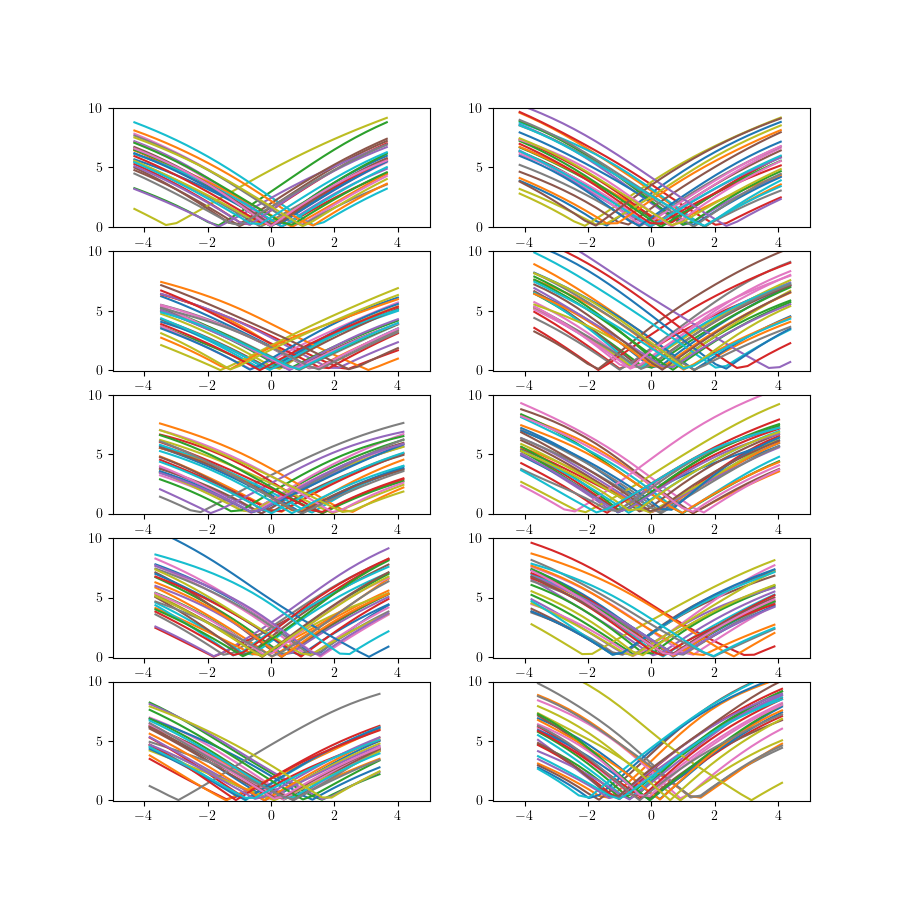

In [207]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


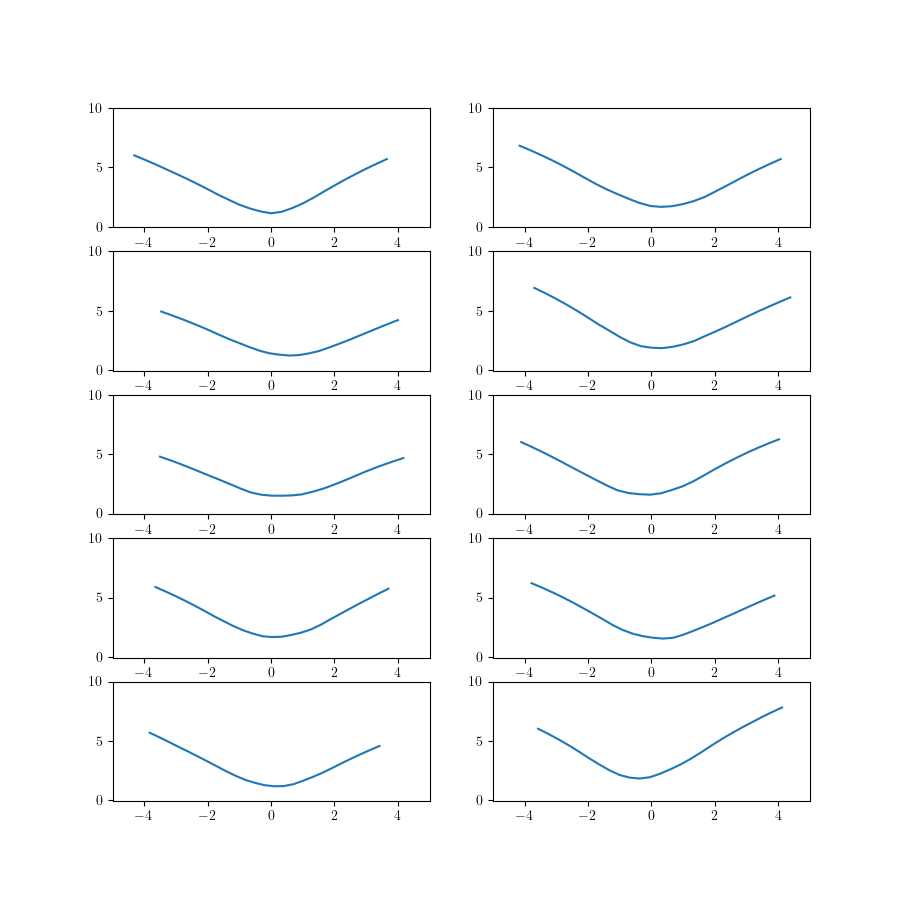

In [208]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1), axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

##### 83\%

In [209]:
gen_sens = np.load(log_path_base + '/5/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)
# list(gen_sens.keys())

<IPython.core.display.Javascript object>


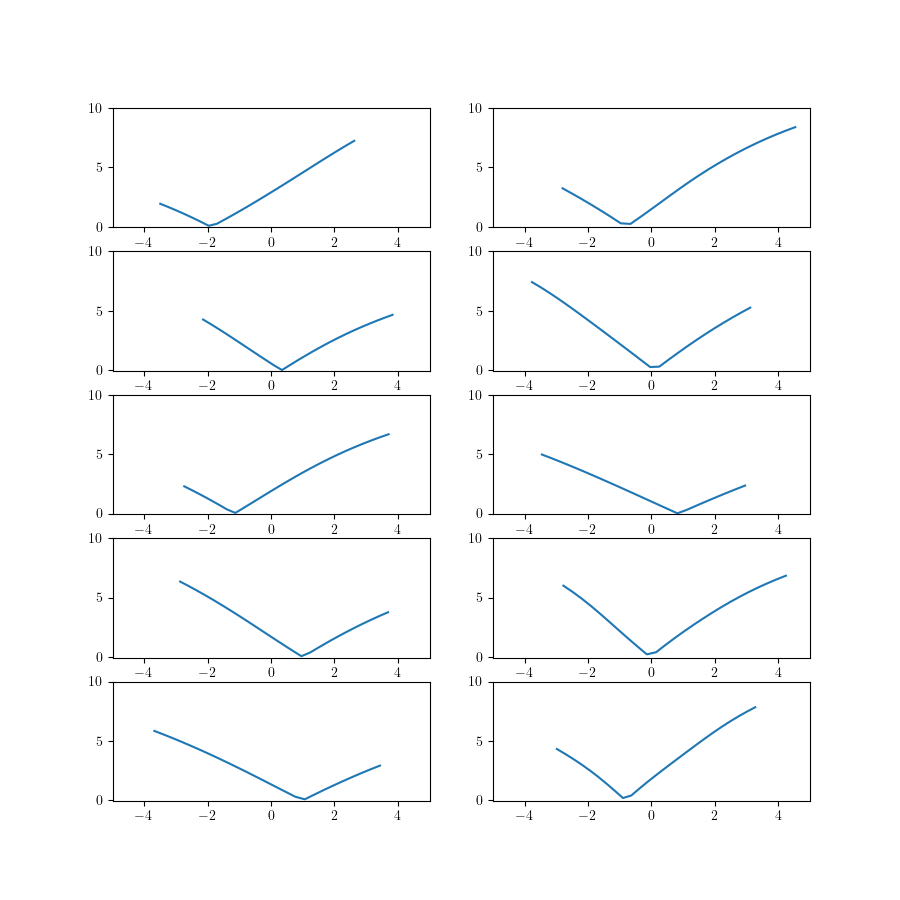

In [210]:
idx = 2

fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'][:, idx, :] - gen_sens['X_mean'][idx], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


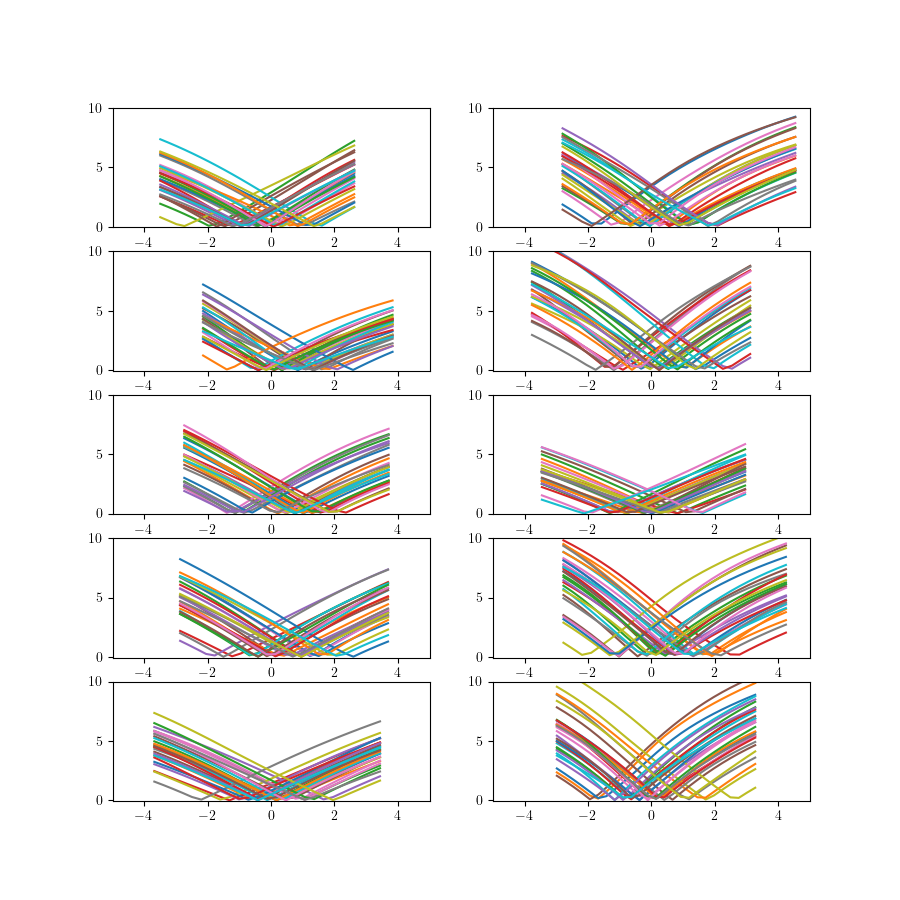

In [211]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


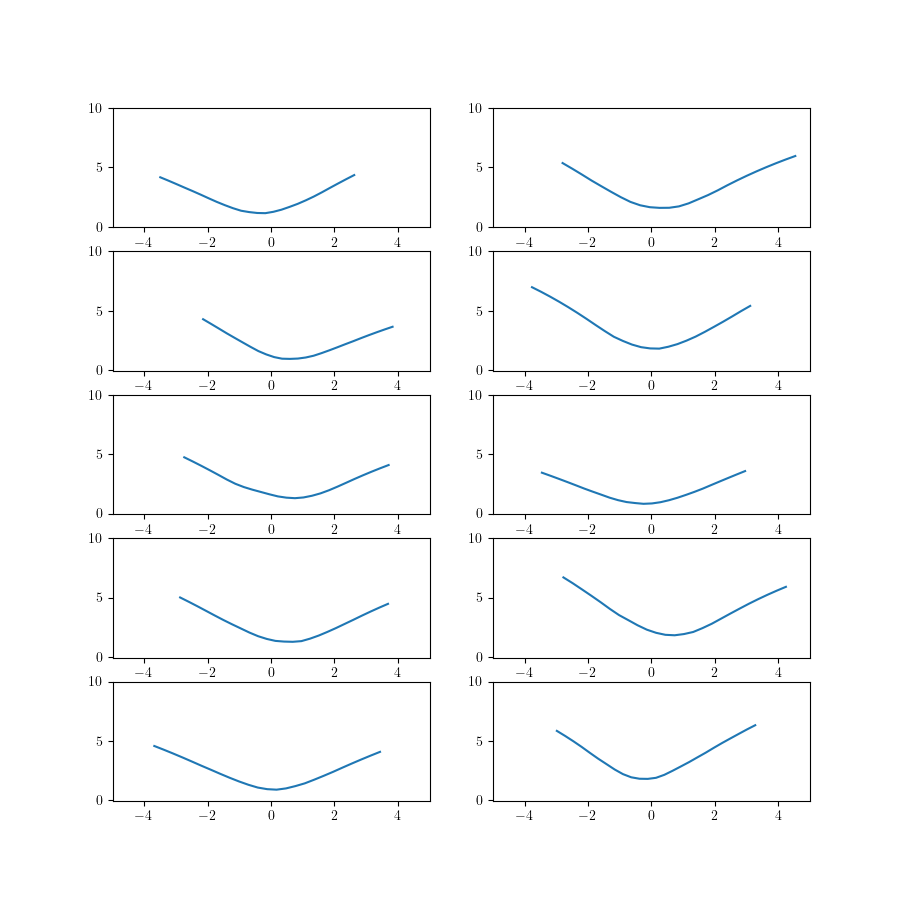

In [212]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1), axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

#### MVAE

##### 16\%

In [213]:
gen_sens = np.load(log_path_base + '/1/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)
# list(gen_sens.keys())

<IPython.core.display.Javascript object>


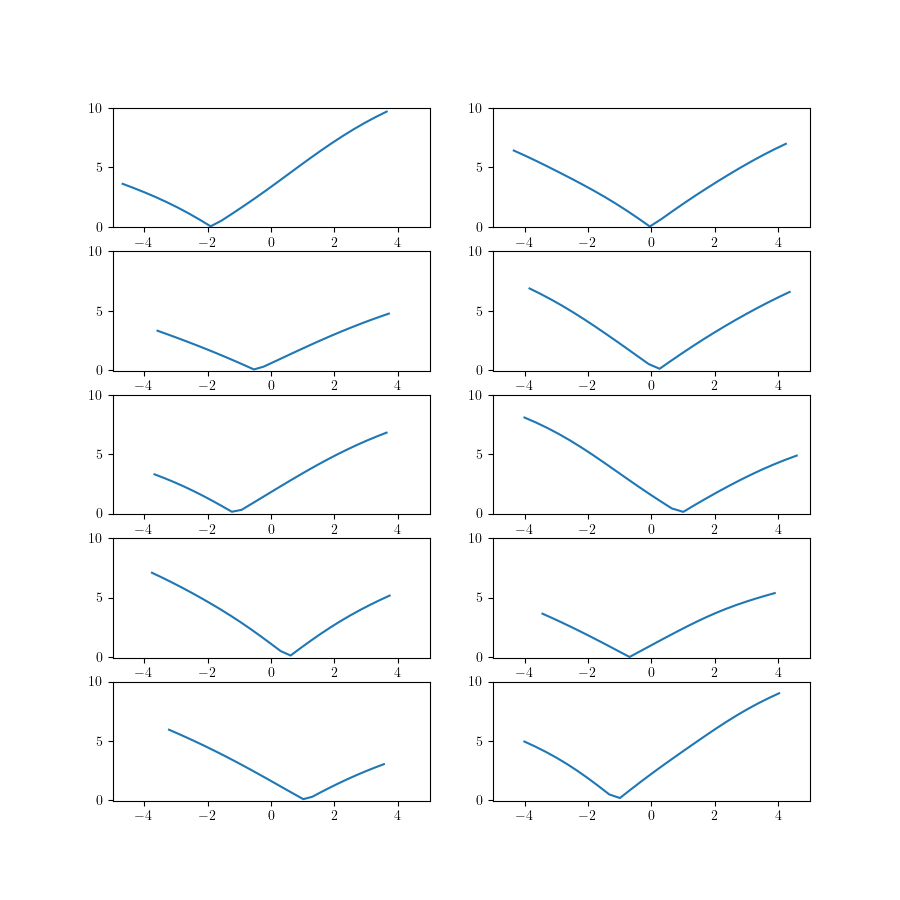

In [214]:
idx = 2

fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'][:, idx, :] - gen_sens['X_mean'][idx], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


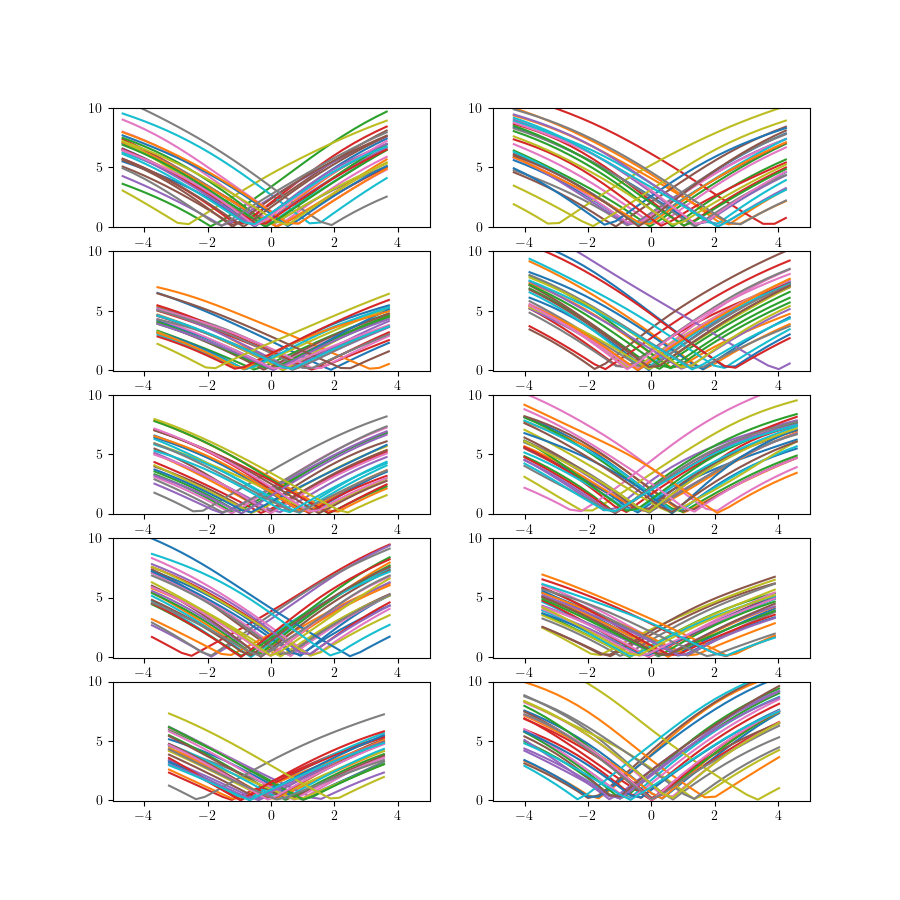

In [215]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


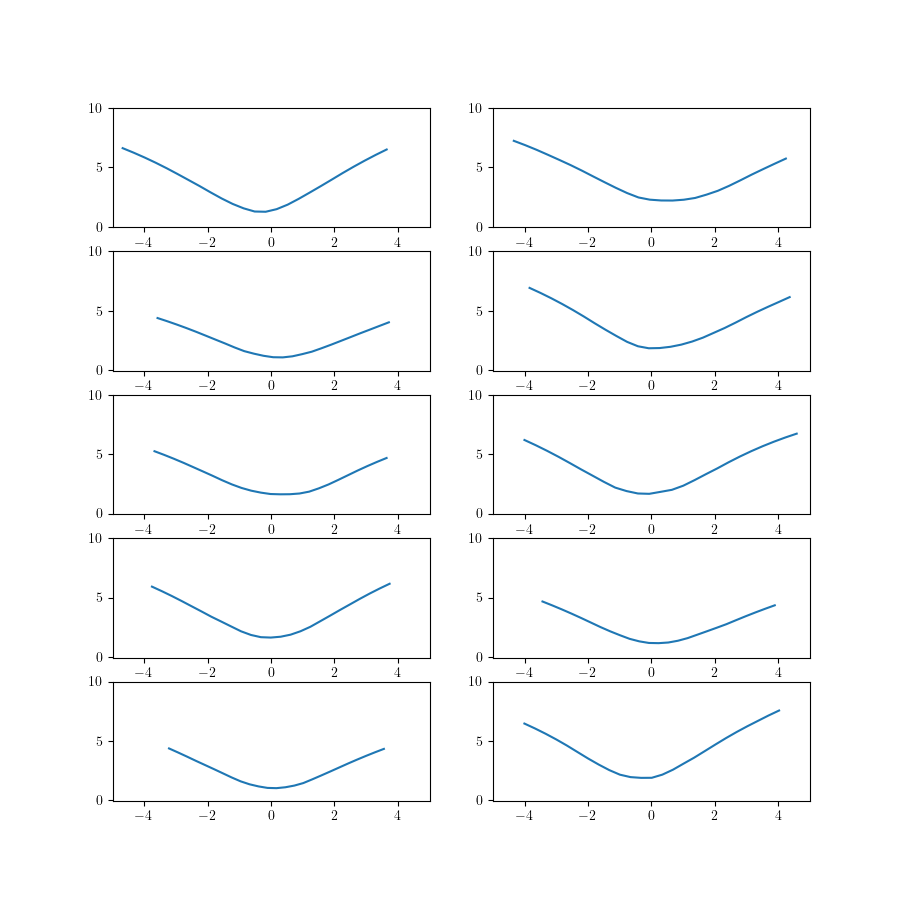

In [216]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1), axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

##### 83\%

In [217]:
gen_sens = np.load(log_path_base + '/5/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)
# list(gen_sens.keys())

<IPython.core.display.Javascript object>


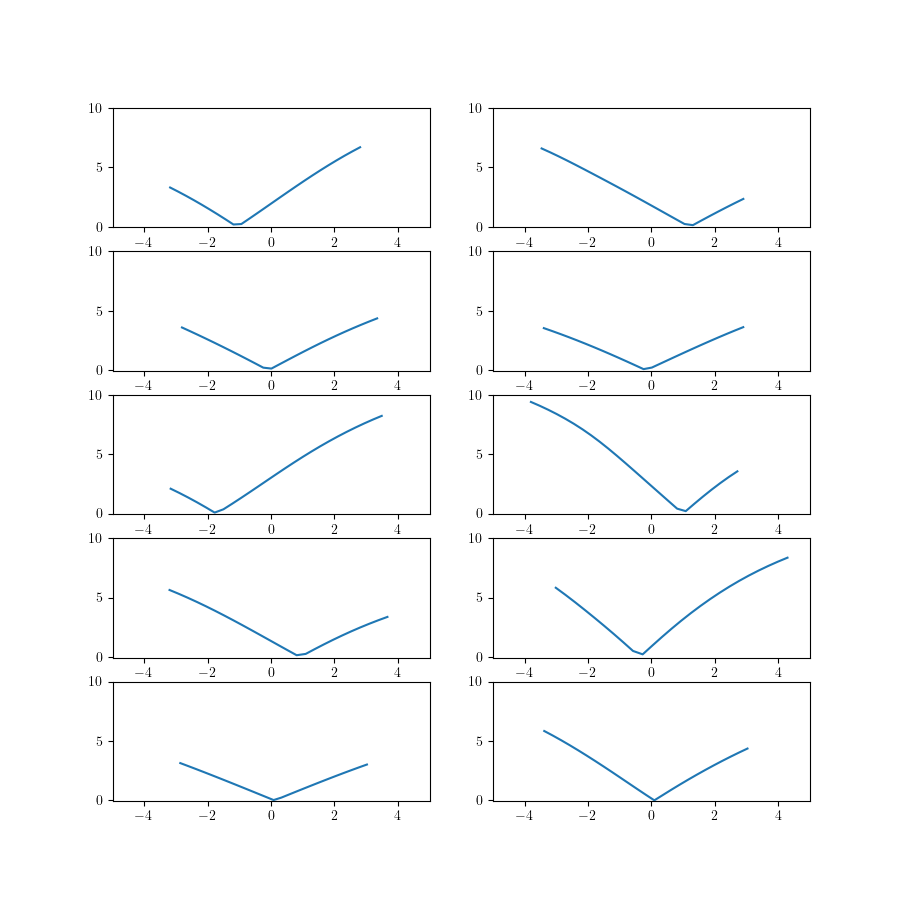

In [218]:
idx = 2

fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'][:, idx, :] - gen_sens['X_mean'][idx], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


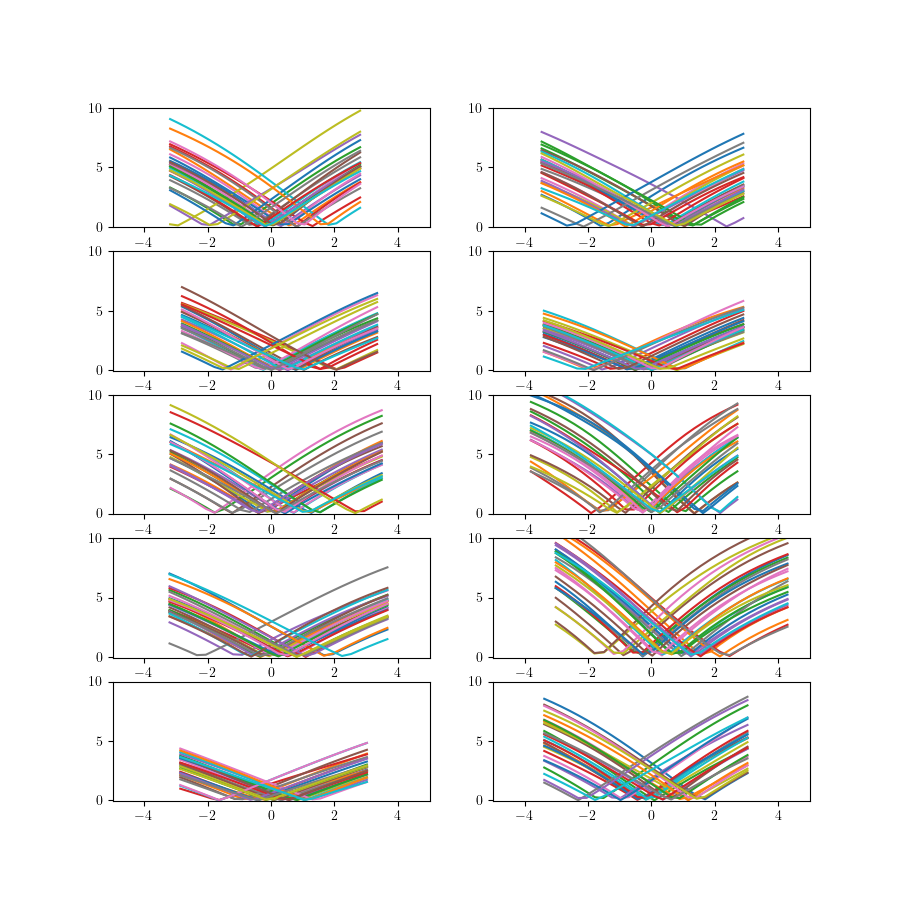

In [219]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

<IPython.core.display.Javascript object>


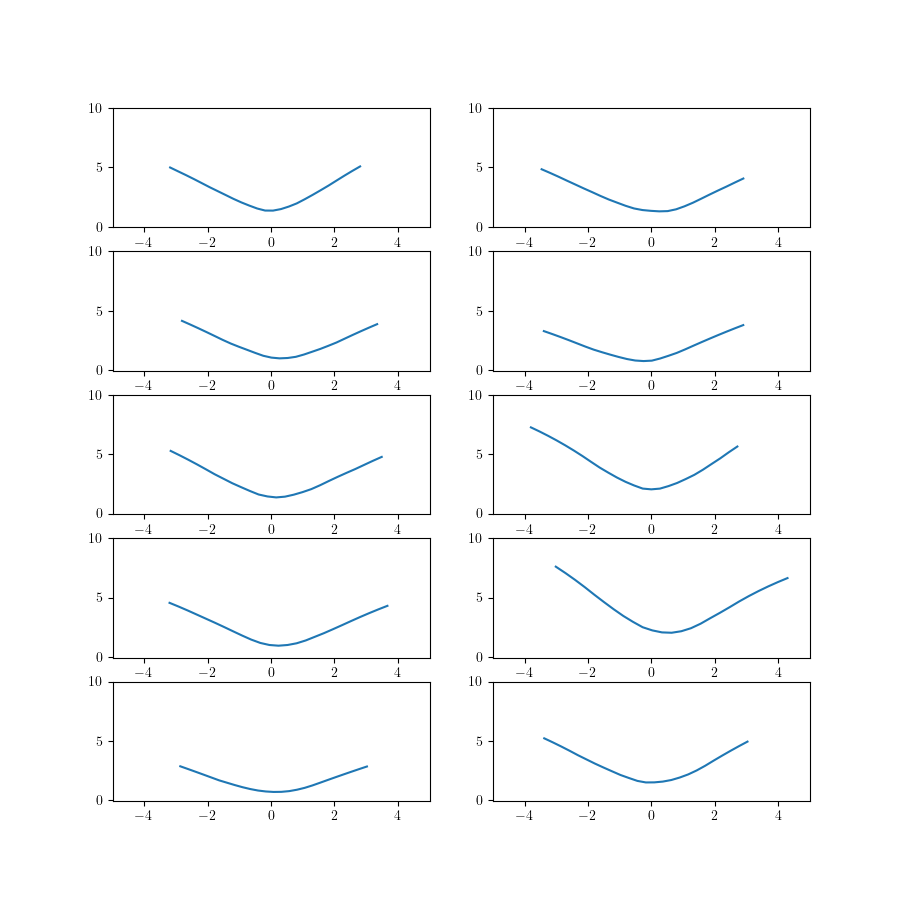

In [220]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens[f'X_mean_{i}'] - gen_sens['X_mean'], axis=-1), axis=-1))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)

#### Average deviation MVAE vs MIWAE

##### 16\%



In [223]:
gen_sens_miwae = np.load(log_path_base + '/1/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)
gen_sens_mvae = np.load(log_path_base + '/1/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)

<IPython.core.display.Javascript object>


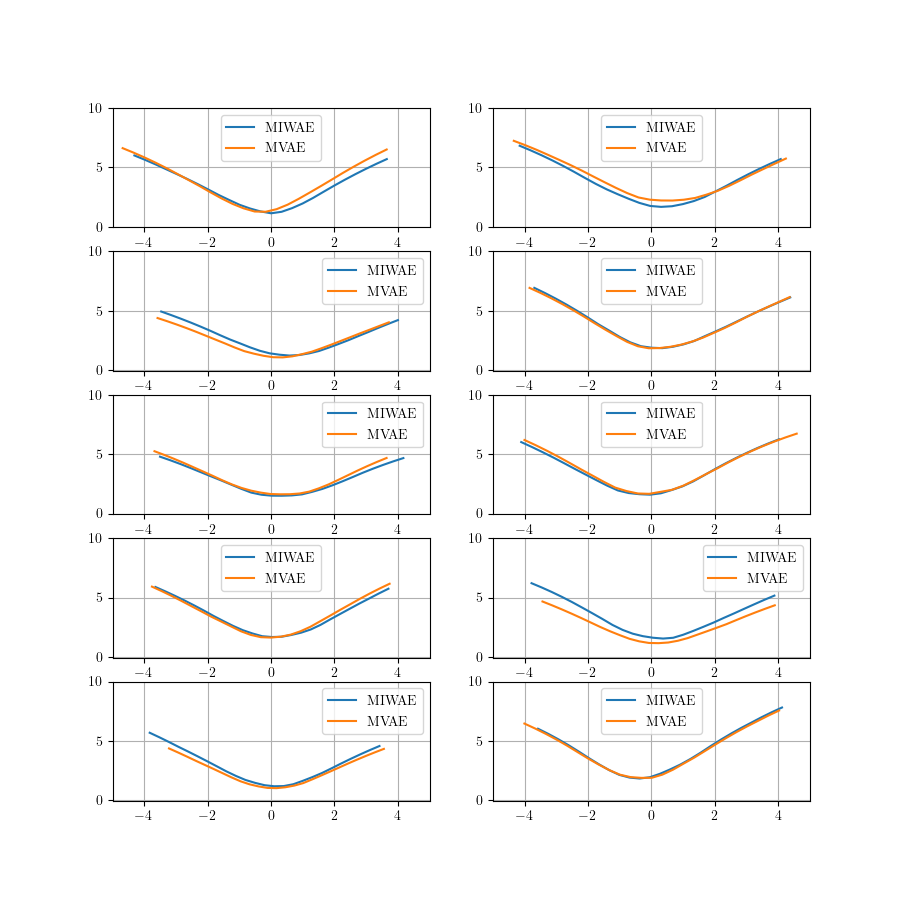

In [226]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens_miwae[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens_miwae[f'X_mean_{i}'] - gen_sens_miwae['X_mean'], axis=-1), axis=-1),
            label='MIWAE')
    ax.plot(gen_sens_mvae[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens_mvae[f'X_mean_{i}'] - gen_sens_mvae['X_mean'], axis=-1), axis=-1),
            label='MVAE')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)
    ax.legend()
    ax.grid()

##### 83\%



In [227]:
gen_sens_miwae = np.load(log_path_base + '/5/fc_miwae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)
gen_sens_mvae = np.load(log_path_base + '/5/fc_mvae/' + exp_seed_keys[0] + '/evaluations/tensors/generator_sensitivity_test.npz', allow_pickle=True)

<IPython.core.display.Javascript object>


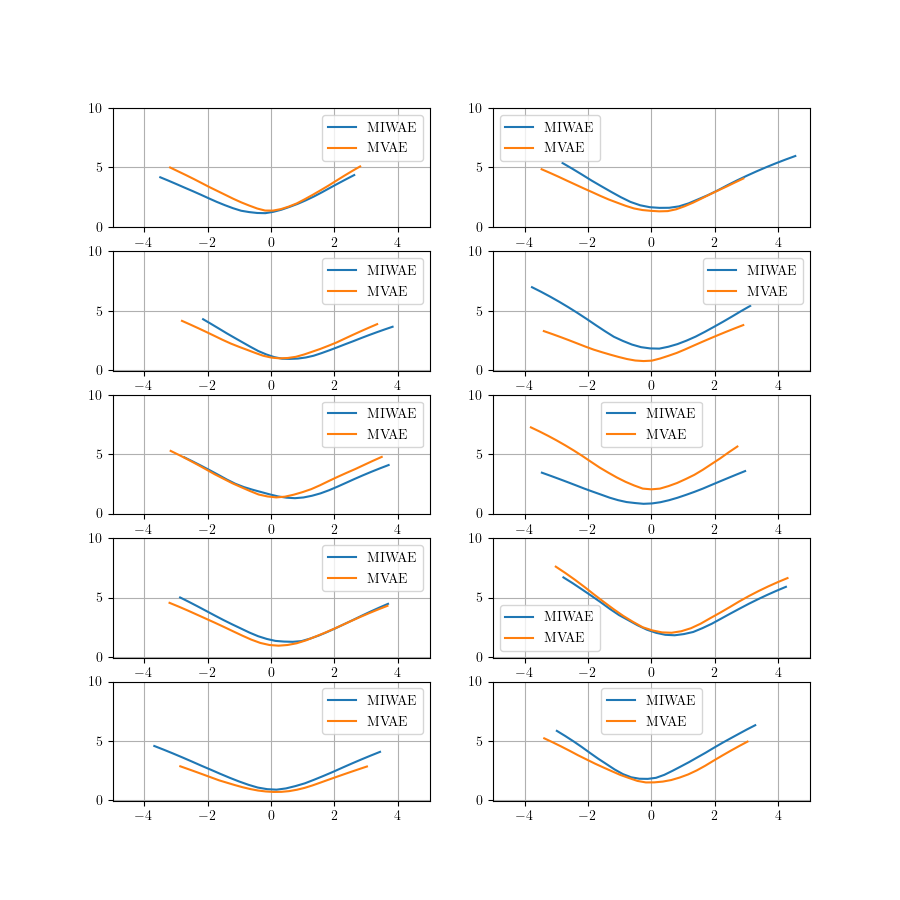

In [228]:
fig, axes = plt.subplots(5, 2, figsize=(9,9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(gen_sens_miwae[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens_miwae[f'X_mean_{i}'] - gen_sens_miwae['X_mean'], axis=-1), axis=-1),
            label='MIWAE')
    ax.plot(gen_sens_mvae[f'z_vals_{i}'],
            np.mean(np.linalg.norm(gen_sens_mvae[f'X_mean_{i}'] - gen_sens_mvae['X_mean'], axis=-1), axis=-1),
            label='MVAE')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-0.05, 10)
    ax.legend()
    ax.grid()